In [40]:
import os
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)
import re
import math
import numpy as np
import pickle
import json
from json import JSONDecodeError
from collections import Counter, defaultdict
from urllib.parse import urlparse
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import scipy.stats as stats
from textblob import TextBlob
from IPython.display import display, Image

from utils import clean_s, clean_url, corr_data, plot_sub_dist, plot_sub_cat_dist
from regress_reddit import DataGetter, LinReg

There are two primary classes: `DataGetter` and `LinReg`. `DataGetter` loads, filters, featurizes, transforms, and otherwise prepares the data for regression. `LinReg` fits the actual regression model(s).

# Preparing data for regression

## Loading, filtering

We can first create a `DataGetter` object to start preparing some data for a regression. The `__init__()` function takes only the name of the data source as an argument.

In [2]:
DG = DataGetter('posts_with_words.pkl')

We can see that the `out_dir` attribute has been initialized, but the `data` and `feats_dict` fields have yet to be initialized. 

In [3]:
DG.__dict__

{'data_fname': 'posts_with_words.pkl',
 'out_dir': '/u/scr/yiweil/Green-American-Lexicon/3_reddit_analysis/posts_with_words.pkl_out',
 'feats_dict': None,
 'data': None}

In [4]:
assert os.path.exists(DG.get_out_dir())

To initialize `self.data`, we call the `load_data()` function:

In [5]:
DG.load_data()
print('Shape of data:',DG.get_data().shape)


Loading data from /u/scr/yiweil/Green-American-Lexicon/3_reddit_analysis/reddit_data/posts_with_words.pkl...
Read data from with dimensions (911496, 36).
Shape of data: (911496, 36)


There are various criteria according to which we'll want to filter the loaded data--excluding posts by bots, from irrelevant subreddits, from subreddits that have been miscategorized and which are actually users, AskMeAnything and ChangeMyView posts--by default these are all set to `True`. 

In addition, by setting `hi_prec_keyword_filter` to `True`, we keep only the posts with at least 2 distinct high precision keywords.

In [6]:
DG.filter_data()


Filtering data...
Excluding posts from 2895 bot users...
	New size of posts: 869922
Excluding posts from 14186 irrelevant subreddits...
	New size of posts: 702917
Excluding posts from a false subreddit that's actually a user...
	New size of posts: 702917
Excluding AMA-type posts...
	New size of posts: 702145
Excluding CMV-type posts...
	New size of posts: 700969
Filtering to posts that contain at least 2 distinct high precision keywords...
	New size of posts: 578861


But we could also do something like `DG.filter_data(exclude_cmv=False)` if we wanted to keep CMV posts.

## Featurizing

Now we get the actual features. In some cases, the keyword args map onto multiple individual features (e.g., setting `sentistrength` to `True` will compute both the positive and negative scores for a post).

The repository by default includes files containing pre-computed features on `posts_with_words.pkl`, and so running the below block will load those cached feature files. If you wish to have the features computed from scratch (which would be necessary if you use a different set of posts entirely), just move the cached feature files to a different location.

Note: If you make changes to the filtering step and leave in more posts than the defaults I use, you will also have to recompute features for those posts.

These are the default settings used in my regressions (i.e., `vader`, `wiebe_subjectivity` and `NRC` are not added as features): 

```
DG.get_features(length=True, url=True, top_N_domains=20, people=True, sentistrength=True, vader=False, 
                textblob=True, wiebe_subjectivity=False, NRC=False, neg=True, nat_disaster=True,
                economy=True, emolex=True, morals=True, values=True)
```

In [7]:
# TO DO: change temp_senti

In [8]:
DG.get_features(length=True, url=True, top_N_domains=20, people=True, sentistrength=True, temp_senti=True, 
                vader=False, textblob=True, wiebe_subjectivity=False, NRC=False, neg=True, nat_disaster=True,
                economy=True, emolex=True, morals=True, values=True)


Adding features...
Adding length feature...
	Done!
Adding cached URL-related features...
	Done!
Adding people-mention features...
	Done!
cached_senti_path: /u/scr/yiweil/green-lexicon/reddit_data/post_sentiment_concatenated.tsv
Found cached feature file at /u/scr/yiweil/green-lexicon/reddit_data/post_sentiment_concatenated.tsv. Adding cached SentiStrength features...
	Done!
Found cached feature file at /u/scr/yiweil/Green-American-Lexicon/3_reddit_analysis/posts_with_words.pkl_out/cached/textblob_scores.pkl. Adding cached TextBlob features...
	Done!
Computing negation feature...
	Done!
Computing natural disaster feature...
	Done!
Computing economy feature...
	Done!
Found cached feature file at /u/scr/yiweil/Green-American-Lexicon/3_reddit_analysis/posts_with_words.pkl_out/cached/emo_intensity_scores.pkl. Adding cached EmoLex features...
	Done!
Found cached feature file at /u/scr/yiweil/Green-American-Lexicon/3_reddit_analysis/posts_with_words.pkl_out/cached/MFD_scores_per_post.tsv. Ad

We see that there are now a lot more columns for the retrieved features:

In [9]:
dg_data = DG.get_data()
len(dg_data.columns)

135

For example, here are the indicator variables for people:

In [10]:
[x for x in dg_data.columns if x.startswith('has_')]

['has_gore',
 'has_obama',
 'has_bezos',
 'has_pruitt',
 'has_bernie',
 'has_dicaprio',
 'has_attenborough',
 'has_thunberg',
 'has_biden',
 'has_nye',
 'has_trump',
 'has_inslee',
 'has_clinton',
 'has_ocasiocortez']

To get categorical versions of continuous features, use the `get_categorical_features` function, which takes the same format of keyword arguments. 

For the positive and negative SentiStrength features, the function maps scores with absolute value > 1 to 1, and scores with absolute value == 1 to 0.

For all other features, the function maps the categorical feature for a given post to 1 if the feature for that post is greater than or equal to the median of non-zero values for that feature, and 0 otherwise. You can also create thresholds based on the mean by passing `threshold=mean` as a keyword argument.

In [11]:
DG.get_categorical_features(senti_pos=True,senti_neg=True,tb_sub=True,
                            emo_anger=True,emo_anticipation=True,emo_disgust=True,
                            emo_fear=True,emo_joy=True,emo_sadness=True,emo_surprise=True,
                            emo_trust=True,negation=True,nat_dis=True,econ=True,
                            vice_purity=True,vice_harm=True,vice_authority=True,
                            vice_fairness=True,vice_loyalty=True,
                            virtue_purity=True,virtue_harm=True,virtue_authority=True,
                            virtue_fairness=True,virtue_loyalty=True,
                            self_direction=True,stimulation=True,hedonism=True,achievement=True,power=True,
                            security=True,conformity=True,tradition=True,benevolence=True,universalism=True)


Getting categorical versions of features...
Creating thresholds for each feature based on median of non-zero values...
Creating categorical features...
	Done!


The below function fills in `self.feats_dict`, to make it easier to keep track of which (types of) features (and feature names) have been added to the data.

In [12]:
DG.set_features()

Found 1 out of 1 possible LENGTH features.
Found 30 out of 37 possible AFFECT features.
Found 30 out of 37 possible AFFECT_CAT features.
Found 4 out of 6 possible LING features.
Found 4 out of 6 possible LING_CAT features.
Found 29 out of 29 possible ALL_URL features.
Found 8 out of 8 possible URL_TYPE features.
Found 21 out of 21 possible URL_DOMAIN features.
Found 14 out of 14 possible PEOPLE features.
Found 1 out of 1 possible TIME features.
Found 79 out of 88 possible CATEGORICAL features.
Found 79 out of 88 possible NON_CATEGORICAL features.

Found 112 total features in data.


So now, each type of feature given in the keys of `DG.get_feats_dict()` maps to a list containing all of the retrieved feature of that type.

The key `non_categorical` maps onto all features, excluding the categorical versions of continuous features obtained using `get_categorical_features()`, so it actually includes features that are inherently categorical like the indicator variables. The key `categorical` maps onto all features, but not including the categorical versions of continuous features and excluding the original continuous versions.

In [13]:
dg_feats_dict = DG.get_feats_dict(ipython_disp=True)

,length,affect,affect_cat,ling,ling_cat,all_url,url_type,url_domain,people,time,categorical,non_categorical
0,log_len,emo_joy,vice_harm_cat,tb_sub,econ_cat,is_right_center,is_left_center,is_independent,has_pruitt,year,vice_harm_cat,emo_joy
1,None,tradition,emo_disgust_cat,negation,negation_cat,is_independent,is_right_center,is_youtube,has_dicaprio,None,emo_disgust_cat,is_right_center
2,None,virtue_harm,power_cat,econ,tb_sub_cat,is_youtube,is_sci,is_twitter,has_nye,None,is_right_center,tradition
3,None,emo_sadness,hedonism_cat,nat_dis,nat_dis_cat,is_twitter,is_center,is_nytimes,has_ocasiocortez,None,power_cat,is_youtube
4,None,hedonism,conformity_cat,None,None,is_nytimes,is_right,is_nbcnews,has_thunberg,None,is_youtube,is_independent
5,None,emo_trust,virtue_harm_cat,None,None,is_right,is_conspiracy,is_theguardian,has_bezos,None,is_independent,is_twitter
6,None,vice_harm,emo_fear_cat,None,None,is_nbcnews,is_questionable,is_imgur,has_gore,None,is_twitter,has_inslee
7,None,security,universalism_cat,None,None,is_left,is_left,is_thehill,has_attenborough,None,has_inslee,is_nytimes
8,None,stimulation,virtue_purity_cat,None,None,is_theguardian,None,is_cnn,has_inslee,None,is_nytimes,is_right
9,None,virtue_loyalty,vice_loyalty_cat,None,None,is_imgur,None,is_bbc,has_biden,None,is_right,virtue_harm


We also need to z-score the features to make the coefficients comparable, and to create residualized features using the residual of length regressed on each feature (since most features are highly correlated with length). 

In [14]:
DG.get_zscores()


Getting zscores...
	Done!


By default, the `resid_by` argument of `get_residuals` is set to `log_len`.

In [15]:
DG.get_residuals()


Getting residuals...
	Done!


Now, there are additional columns for features that have been zscored and residualized, except `log_len`, which has just been zscored:

In [16]:
[x for x in dg_data.columns if x.endswith('zscore_resid')][:10]

['emo_joy_zscore_resid',
 'tradition_zscore_resid',
 'virtue_harm_zscore_resid',
 'emo_sadness_zscore_resid',
 'hedonism_zscore_resid',
 'emo_trust_zscore_resid',
 'vice_harm_zscore_resid',
 'security_zscore_resid',
 'stimulation_zscore_resid',
 'virtue_loyalty_zscore_resid']

In [19]:
assert 'log_len_zscore' in dg_data.columns and 'log_len_zscore_resid' not in dg_data.columns

And we can also visualize the general distributions for different features:


Creating figures...


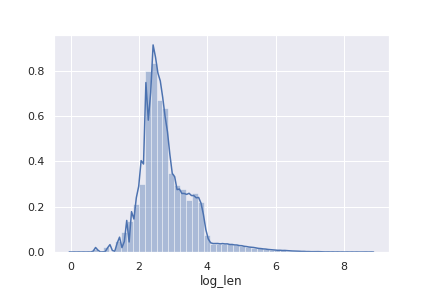

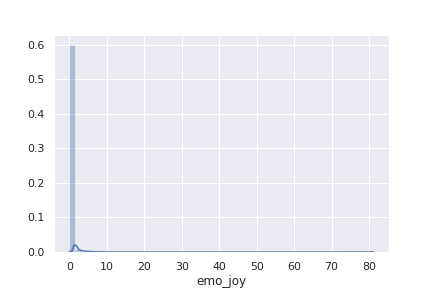

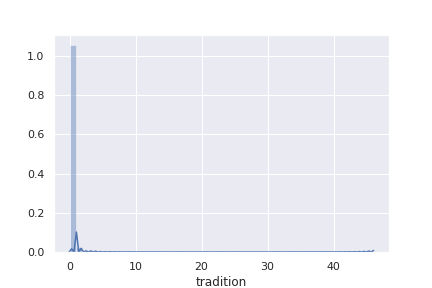

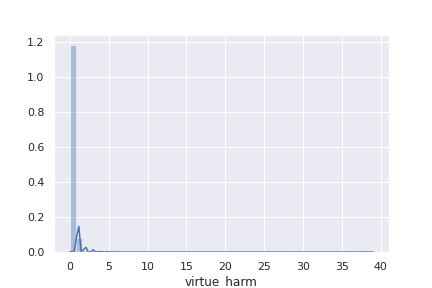

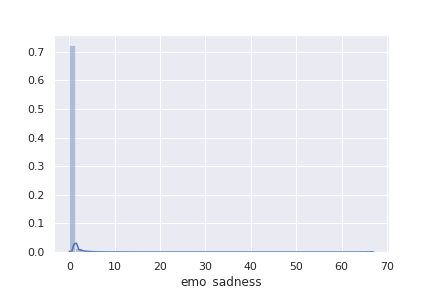

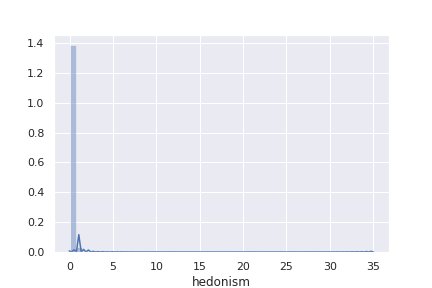

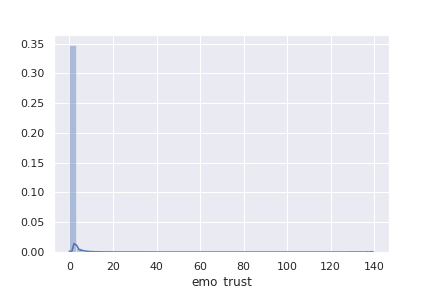

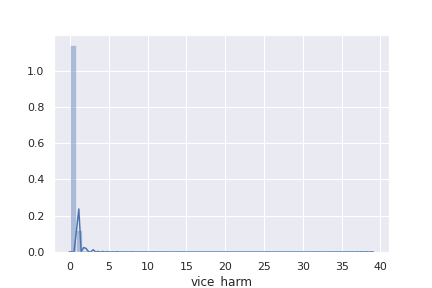

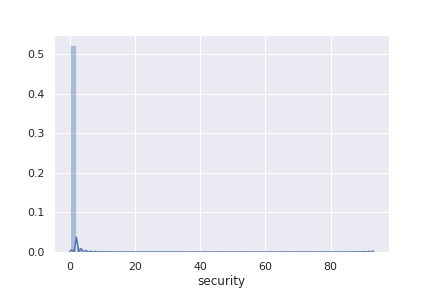

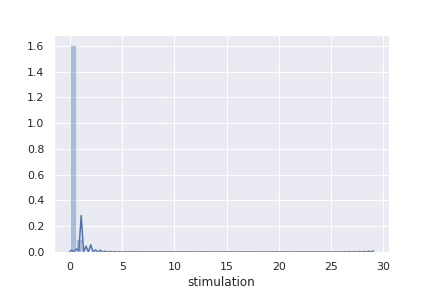

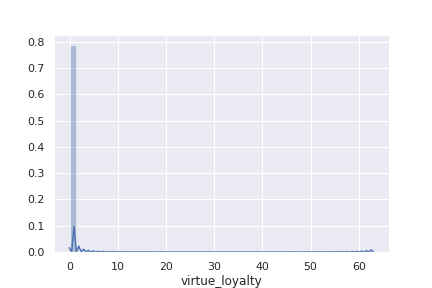

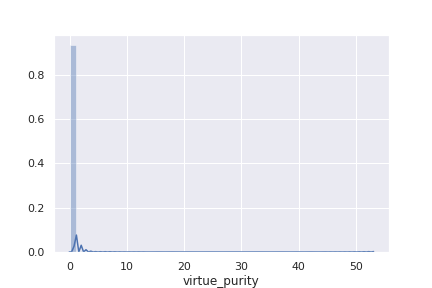

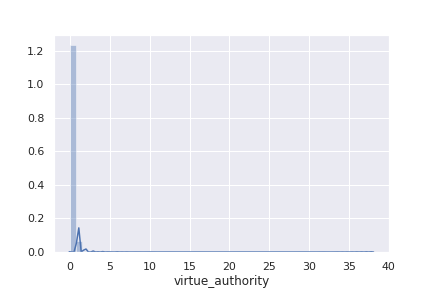

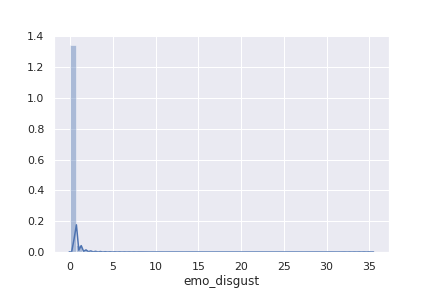

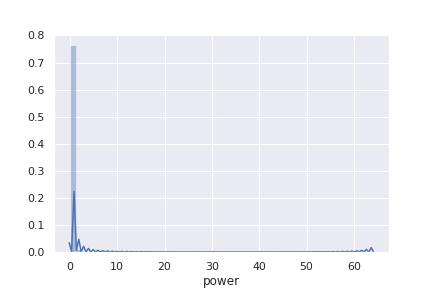

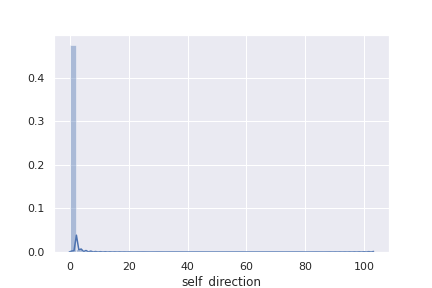

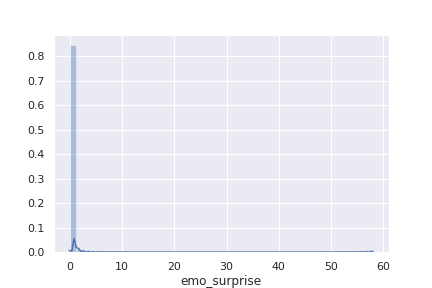

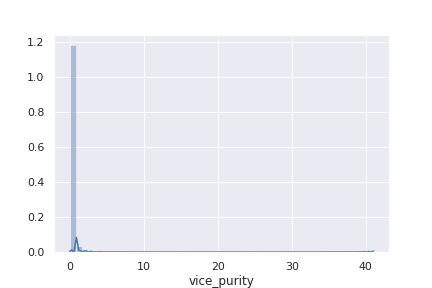

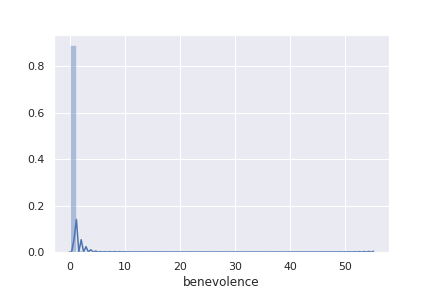

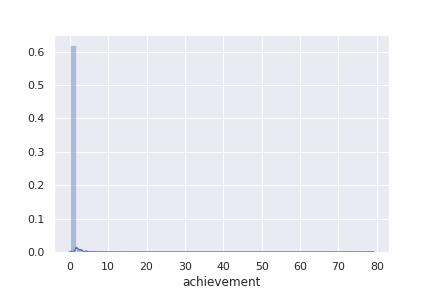

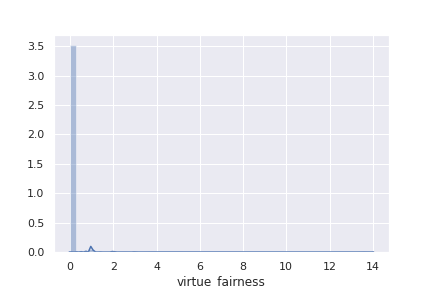

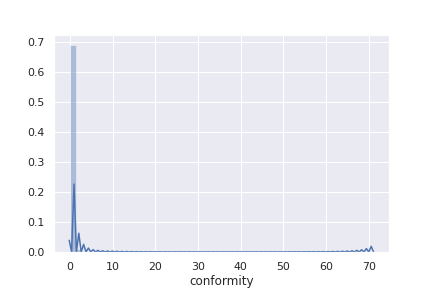

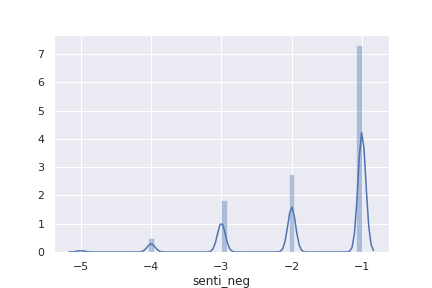

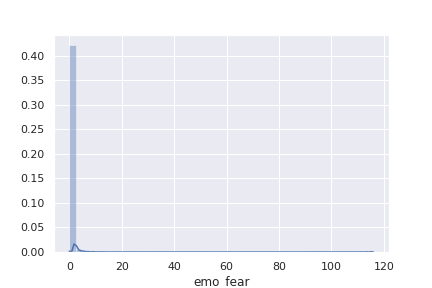

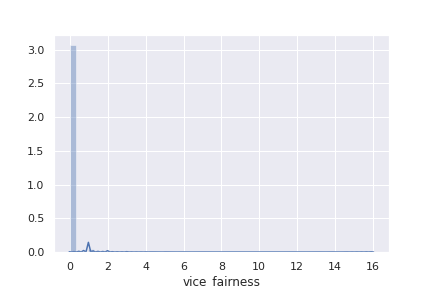

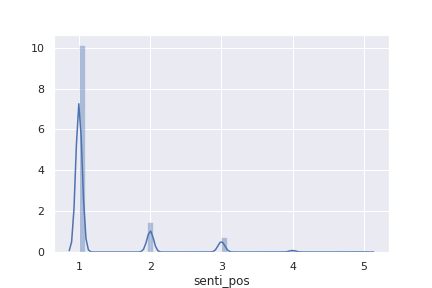

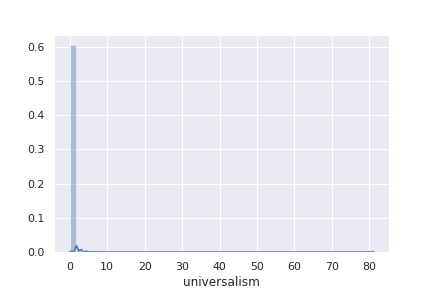

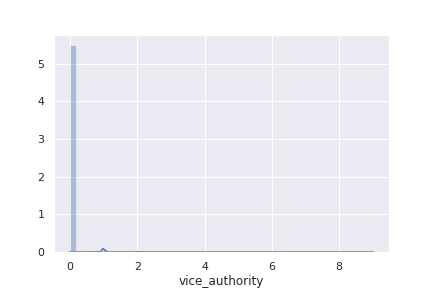

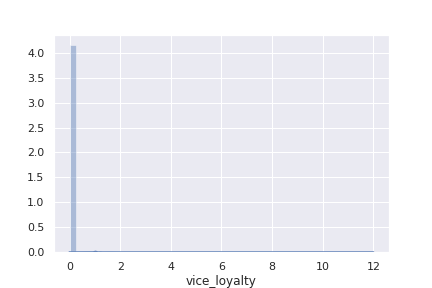

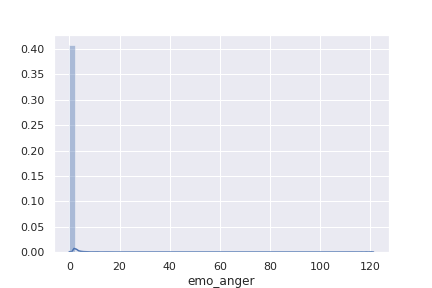

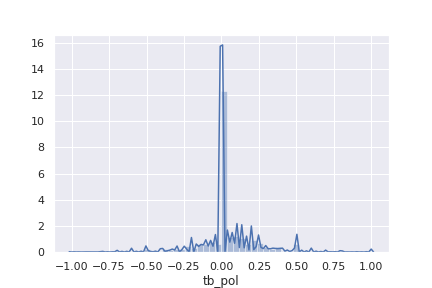

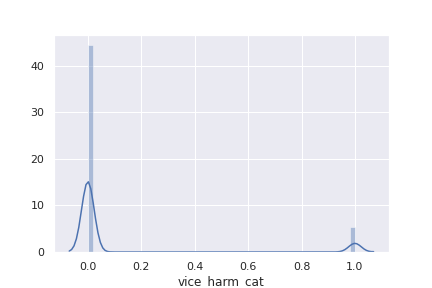

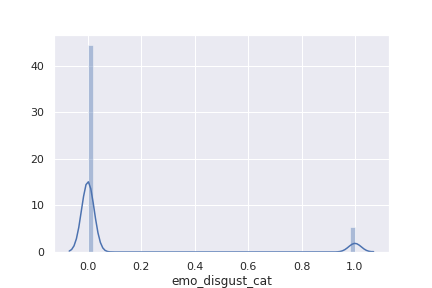

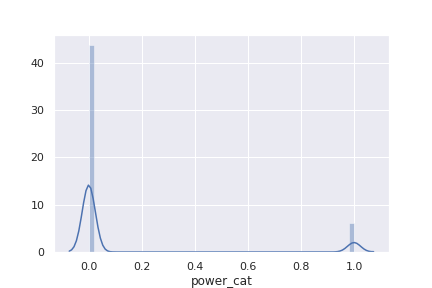

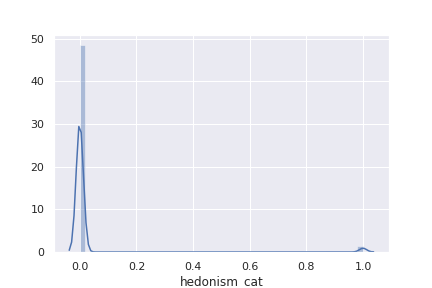

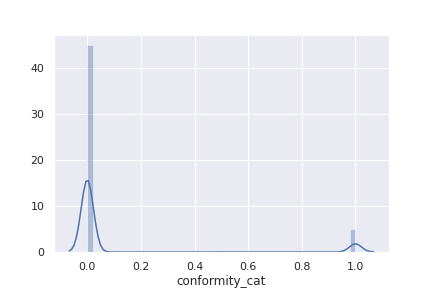

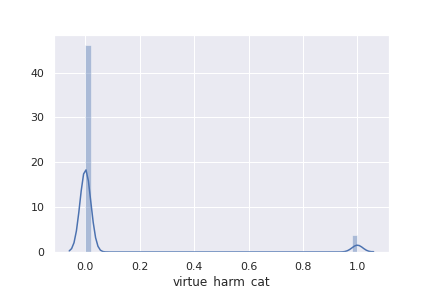

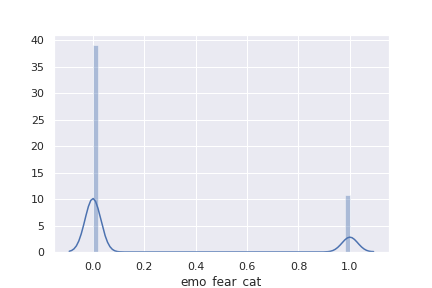

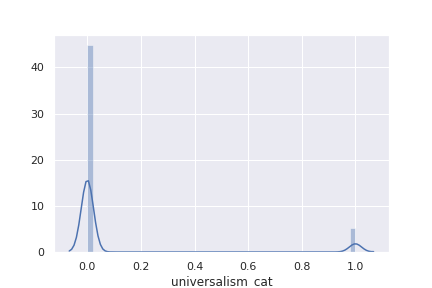

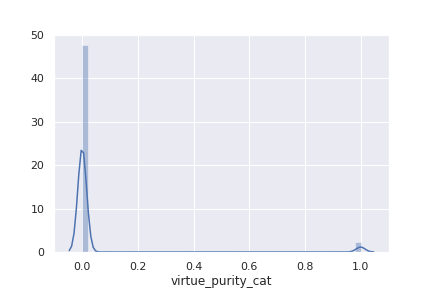

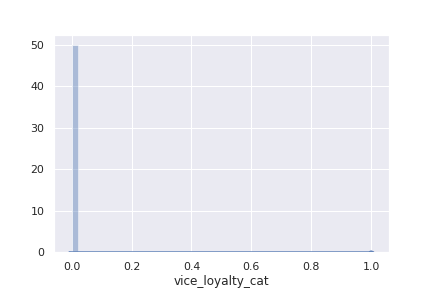

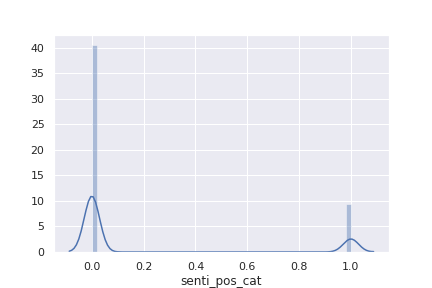

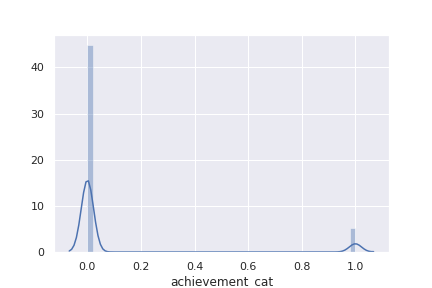

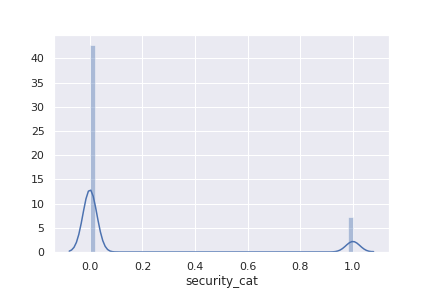

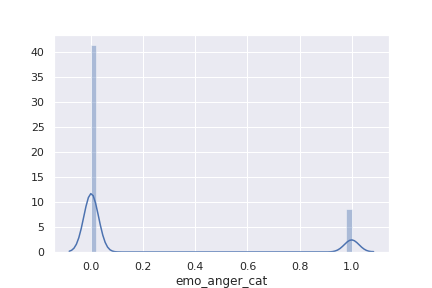

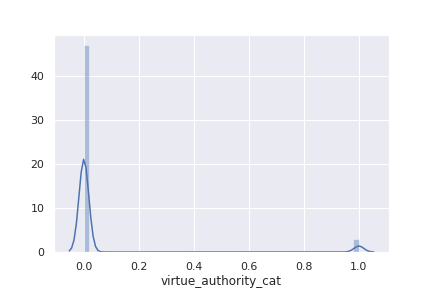

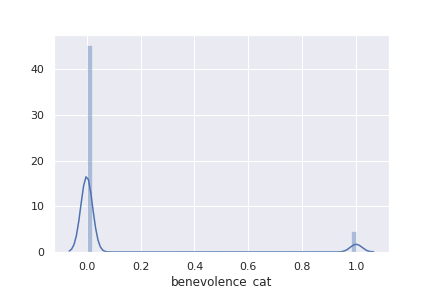

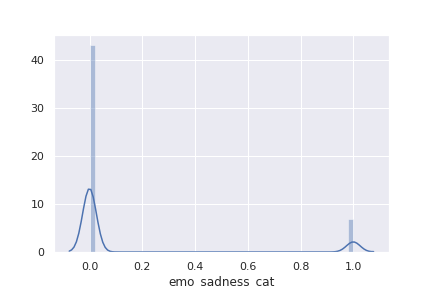

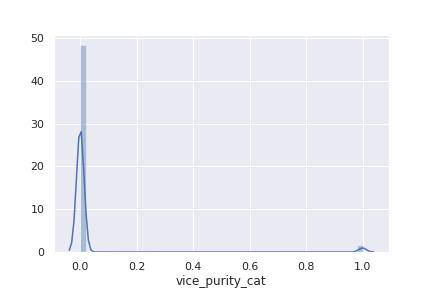

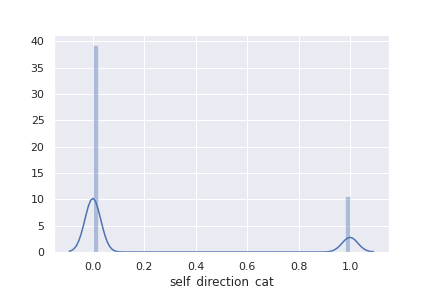

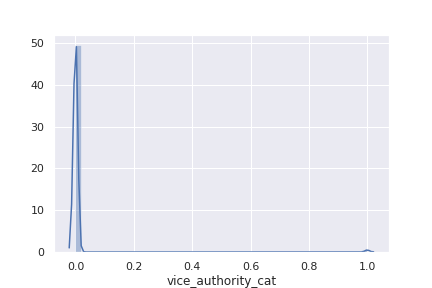

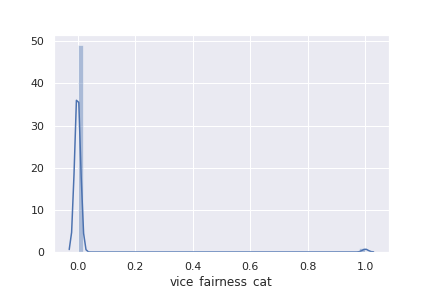

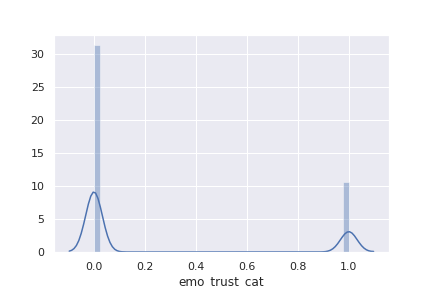

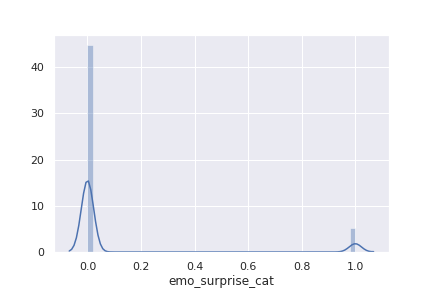

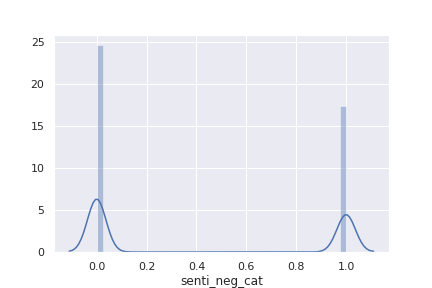

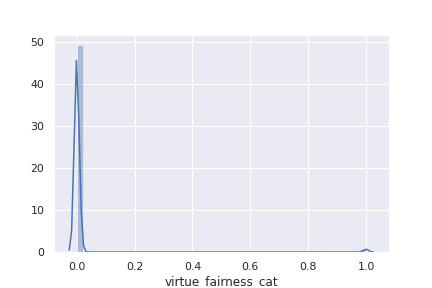

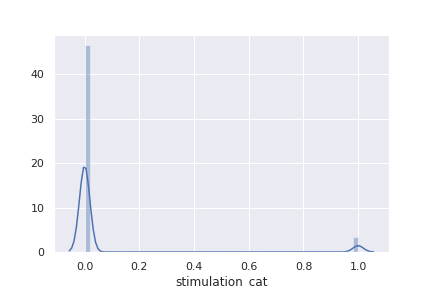

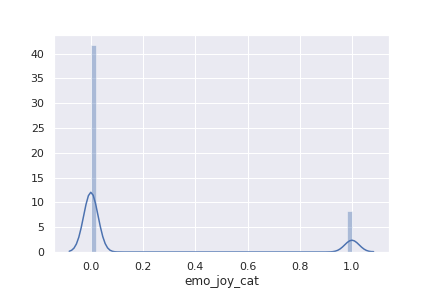

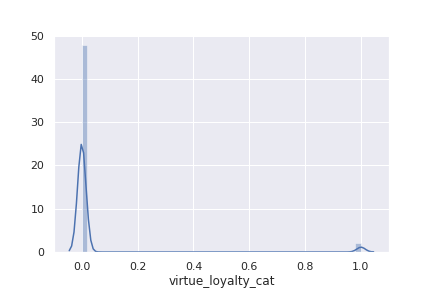

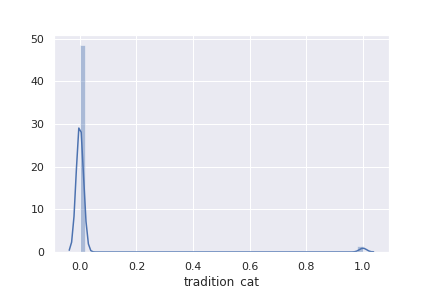

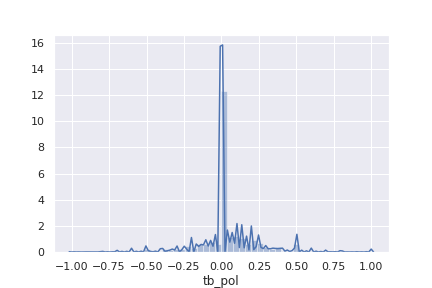

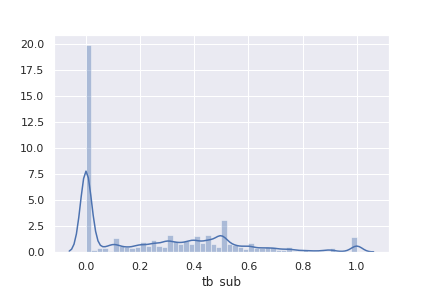

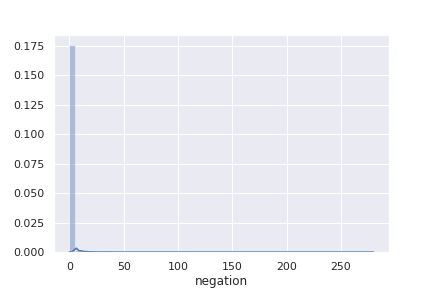

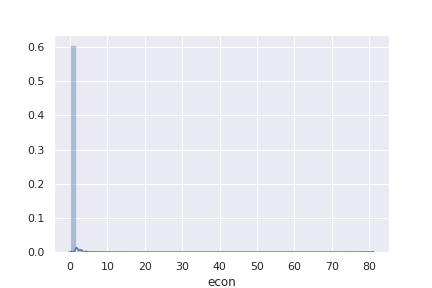

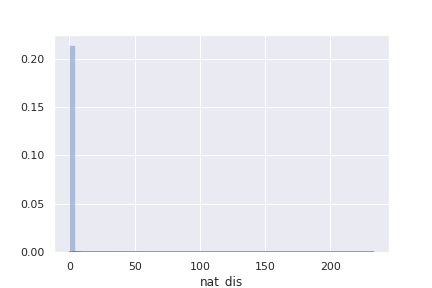

KeyError: 'url'

<Figure size 432x288 with 0 Axes>

In [18]:
DG.plot_features(ipython_disp=True)

These figures are saved to a `/figs` subdirectory in the output directory (`posts_with_words.pkl_out`) regardless of whether `ipython_disp` is set to `True`.

# Regressing data

Now let's do some linear regression. 

As the below error message indicates, to create a `LinReg` instance, we need to pass arguments for `base_df` (the data to regress), `base_df_name` (a short description of the data to regress), `ind_vars` (a list with the names of columns from `base_df` to use as features), and `dep_vars` (a list with the name(s) of dependent variables to use).

In [23]:
LR = LinReg()

TypeError: __init__() missing 3 required positional arguments: 'base_df', 'base_df_name', and 'ind_vars'

We can use `dg_data` (which stores `DG.get_data()`) as the argument for `base_df`. 
To determine what to pass to `ind_vars`, we can examine `DG.get_feats_dict()` to see what the names of all the different 
types of features are:

In [20]:
dg_feats_dict = DG.get_feats_dict()
dg_feats_dict.keys()

dict_keys(['length', 'affect', 'affect_cat', 'ling', 'ling_cat', 'all_url', 'url_type', 'url_domain', 'people', 'time', 'categorical', 'non_categorical', 'zscored', 'resid'])

In addition to `log_len`, let's use a subset of the residualized features (that were first zscored) as `ind_vars`. Let's use the subset of variables that has categorical versions of continuous variables.

In [21]:
ind_vars = [f for f in dg_feats_dict['resid'] 
            if f.replace('_zscore','').replace('_resid','') in dg_feats_dict['categorical']]+['log_len_zscore']
len(ind_vars)

79

Now we can initialize our linear regression with these inputs:

In [22]:
LR = LinReg(dg_data,'default_post_data',ind_vars)


Creating a regression for DEFAULT_POST_DATA with 79 features.
Additional regressions for the following subsets of posts will be created: ['all_posts', 'posts_without_links', 'conservative_posts', 'non_conservative_posts', 'non_zero_engagement_posts']


We see also that the `LR` instance has the following attributes:

In [24]:
LR.__dict__.keys()

dict_keys(['base_df', 'base_df_name', 'ind_vars', 'collinear_feats', 'dep_vars', 'formulas', 'subsets', 'data_dir', 'sig_results'])

By default, `dep_vars` and `subsets` are initialized to the values below, but they can be altered and passed as keyword arguments to the init function.

In [25]:
LR.__dict__['dep_vars']

['log_num_comments', 'log_score', 'ratio_comments']

In [26]:
LR.__dict__['subsets']

['all_posts',
 'posts_without_links',
 'conservative_posts',
 'non_conservative_posts',
 'non_zero_engagement_posts']

Before we can fit a regression model, we need to do the following:
* check for multicollinearity using the `get_VIF()` function,
* create the regression formulas interpretable by the statsmodels API using `get_formulas()`,
* prepare the dependent variables using `get_Ys()` (log transform for most cases),
* create subsets of `base_df` according to those listed in `self.subsets`, each of which will get its own fitted models

In [27]:
LR.get_VIF()


Calculating VIF scores (this takes a while)...
--  ----  ---------------------------------
 0  1     Intercept
71  1     has_attenborough_zscore_resid
65  1     has_dicaprio_zscore_resid
58  1     is_satire_zscore_resid
79  1     log_len_zscore
34  1.01  nat_dis_cat_zscore_resid
54  1.01  is_conspiracy_zscore_resid
70  1.01  has_gore_zscore_resid
68  1.01  has_thunberg_zscore_resid
66  1.01  has_nye_zscore_resid
64  1.01  has_pruitt_zscore_resid
73  1.01  has_biden_zscore_resid
72  1.01  has_inslee_zscore_resid
11  1.01  vice_loyalty_cat_zscore_resid
76  1.01  has_clinton_zscore_resid
32  1.01  negation_cat_zscore_resid
69  1.01  has_bezos_zscore_resid
67  1.02  has_ocasiocortez_zscore_resid
44  1.02  is_imgur_zscore_resid
77  1.02  has_obama_zscore_resid
20  1.02  self_direction_cat_zscore_resid
21  1.02  vice_authority_cat_zscore_resid
22  1.02  vice_fairness_cat_zscore_resid
74  1.02  has_bernie_zscore_resid
31  1.03  econ_cat_zscore_resid
27  1.03  stimulation_cat_zscore_resid
26 

Now we see that `self.collinear_feats` has been updated:

In [28]:
LR.get_collinear_feats()

array([], dtype=object)

In [29]:
LR.get_Ys()


Getting the log transforms of the following dependent variables: ['log_num_comments', 'log_score', 'ratio_comments']
	Done!


In [30]:
LR.get_formulas()


Getting regression formulas...


In [31]:
LR.get_sub_frames()


Getting subframes for regression...
Created subframe of posts without links, with dimensions: (119417, 394)
Created subframe of conservative posts, with dimensions: (43924, 394)
Created subframe of non conservative posts, with dimensions: (534194, 394)
Created subframe of non zero engagement posts, with dimensions: (534194, 394)


Now we can fit some regressions. The following function iterates over all regression formulas (swapping out different dependent variables, excluding subsets of collinear variables) and different subsets of `base_df` as specified.

In [32]:
LR.batch_regress(out_dir=DG.get_out_dir())


Doing regressions...
Regressing subset with: ALL POSTS
Regressing subset with: POSTS WITHOUT LINKS
Regressing subset with: CONSERVATIVE POSTS
Regressing subset with: NON CONSERVATIVE POSTS
Regressing subset with: NON ZERO ENGAGEMENT POSTS
Found 625 significant coefficients from 1200 coefficients total.


Now there's a dataframe with the significant results in the passed `out_dir` called `sig_results.tsv`; full results are saved to `full_results.tsv`.

In [33]:
sig_results = pd.read_csv(DG.get_out_dir()+'/sig_results.tsv',sep='\t',header=0)

In [34]:
dg_feats_dict.keys()

dict_keys(['length', 'affect', 'affect_cat', 'ling', 'ling_cat', 'all_url', 'url_type', 'url_domain', 'people', 'time', 'categorical', 'non_categorical', 'zscored', 'resid'])

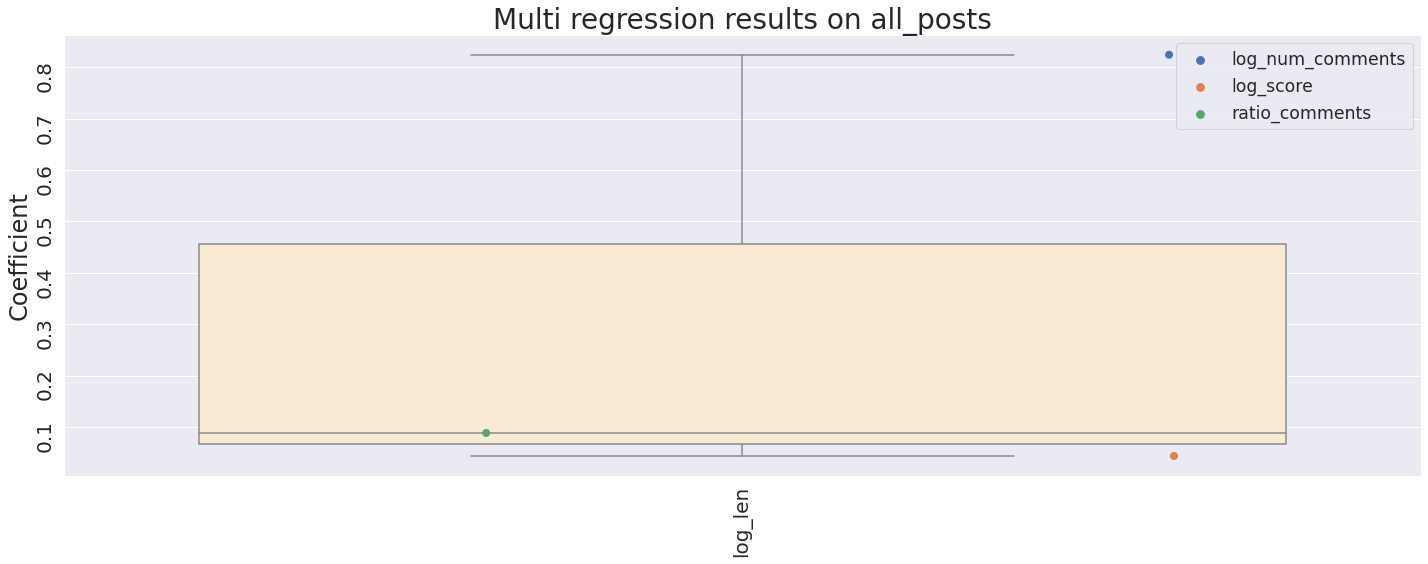

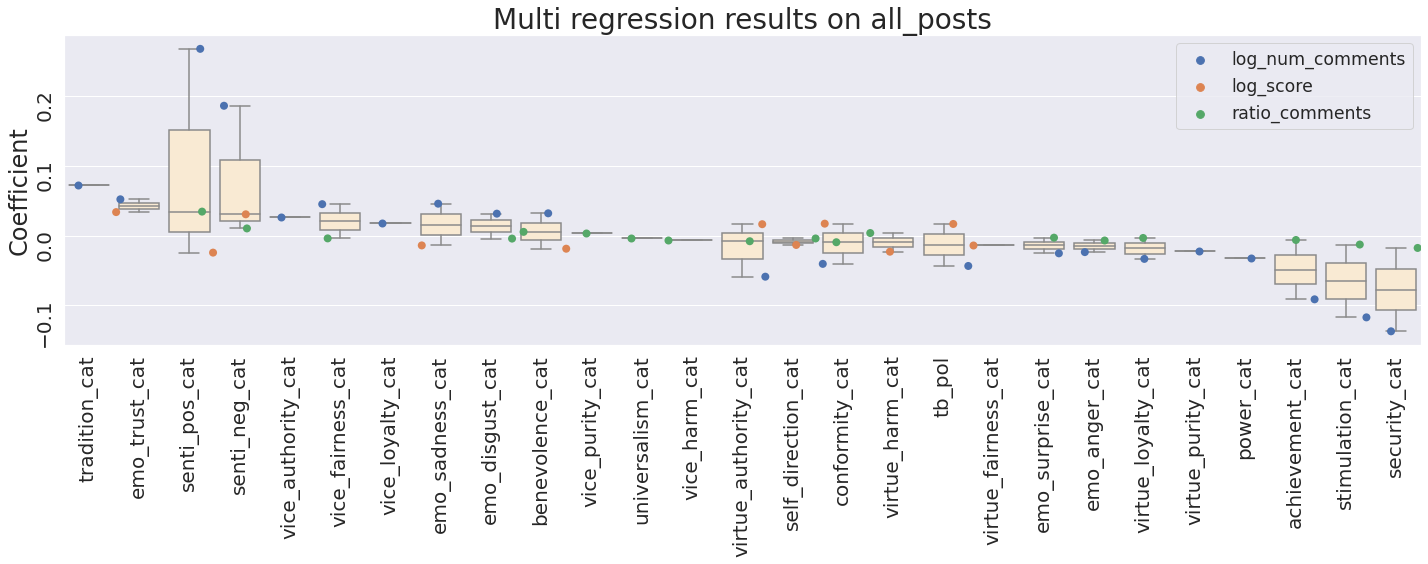

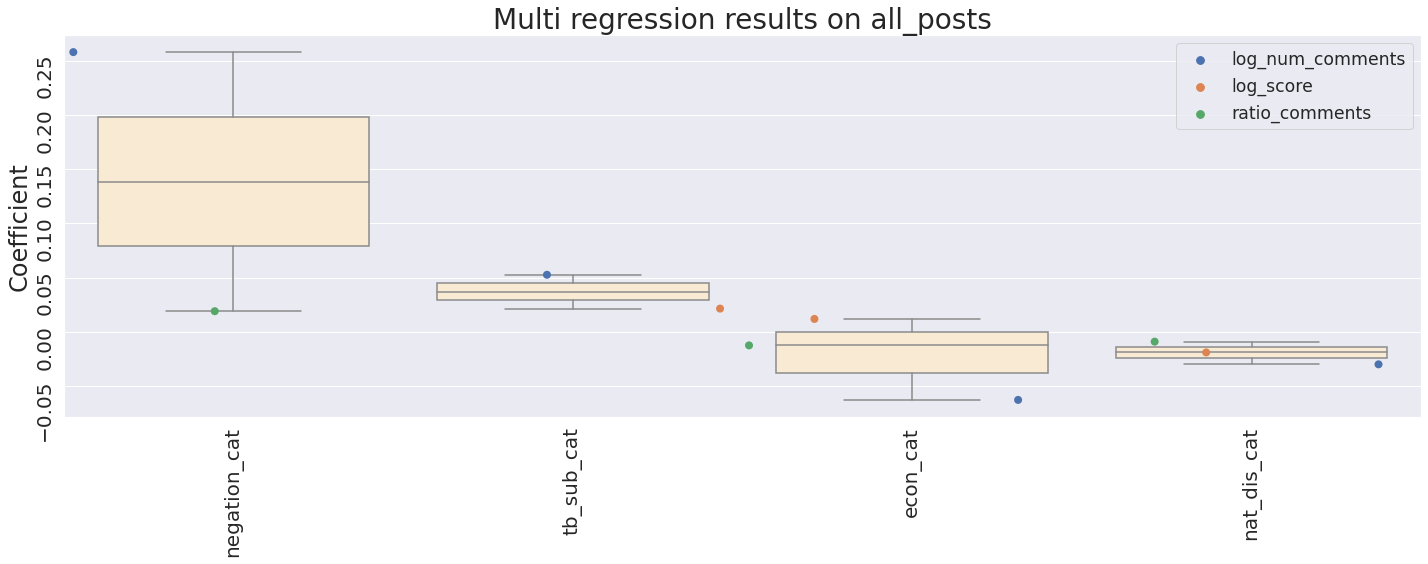

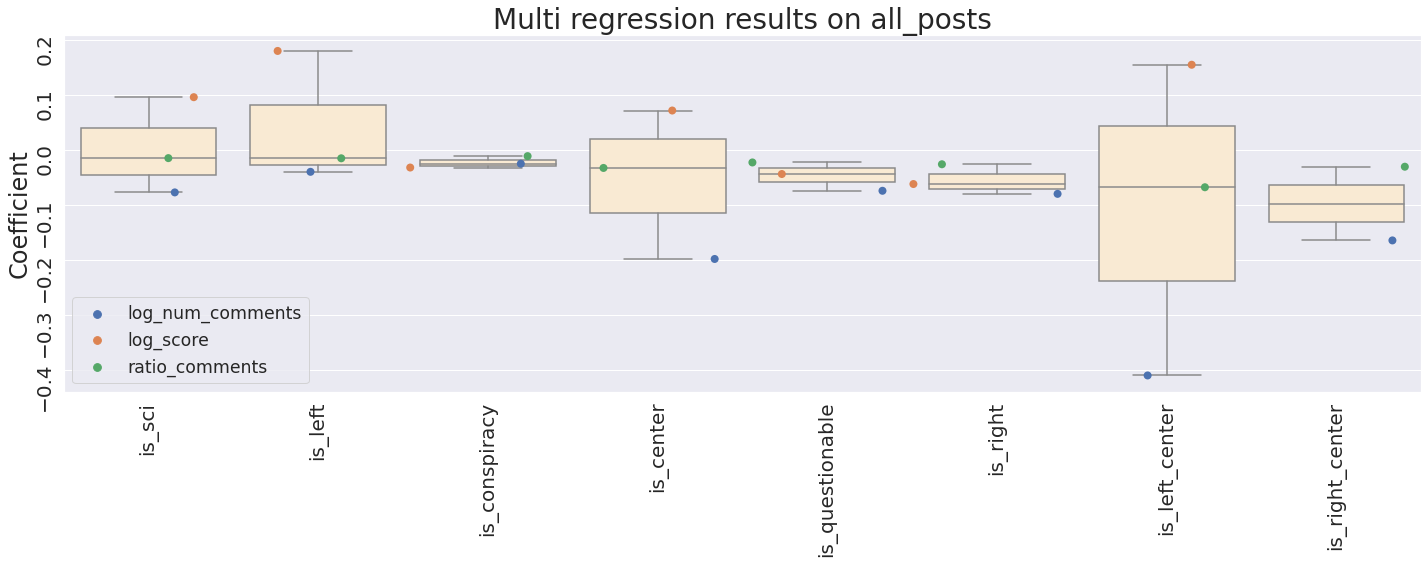

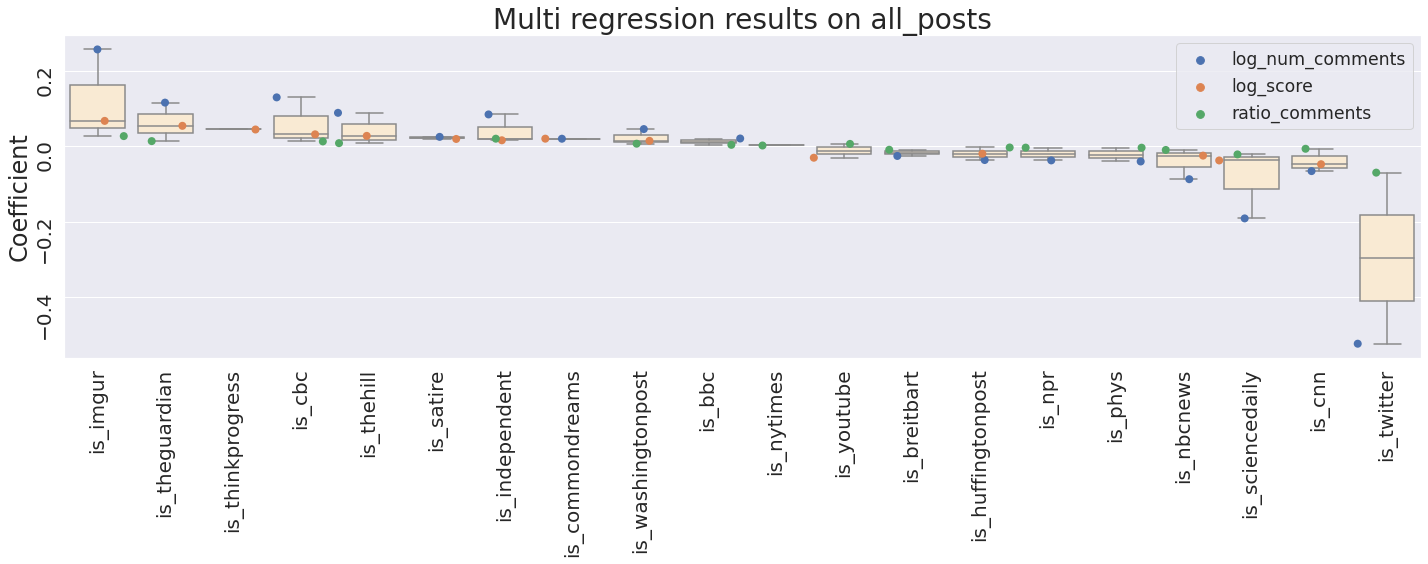

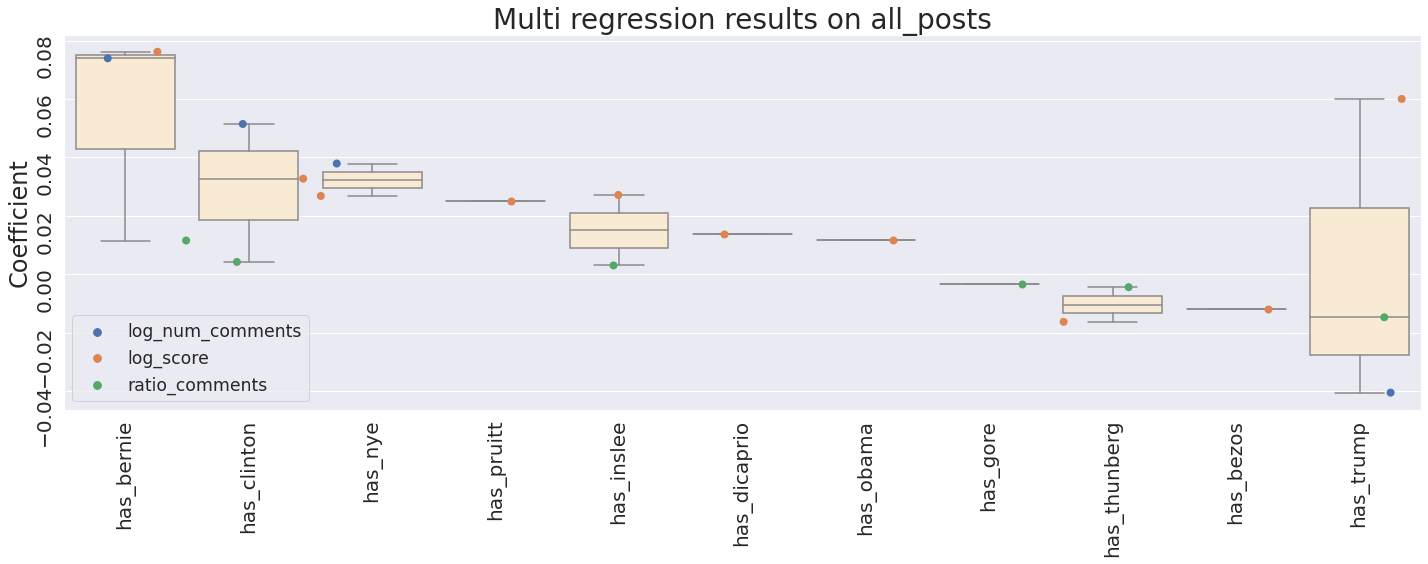

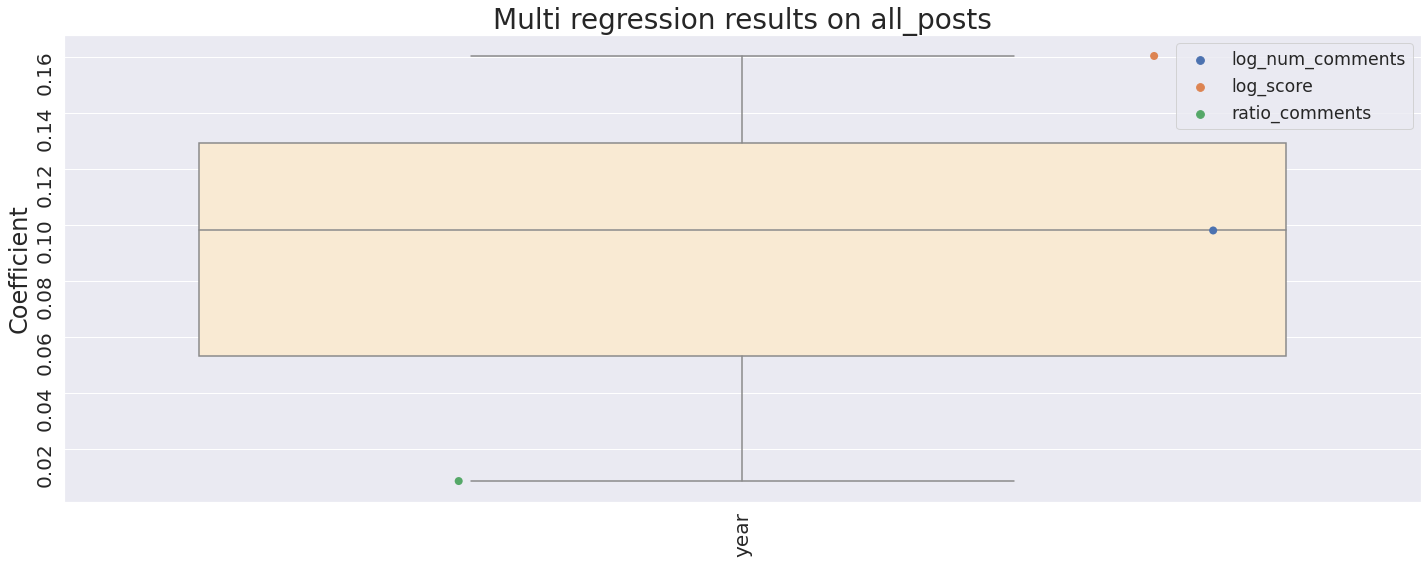

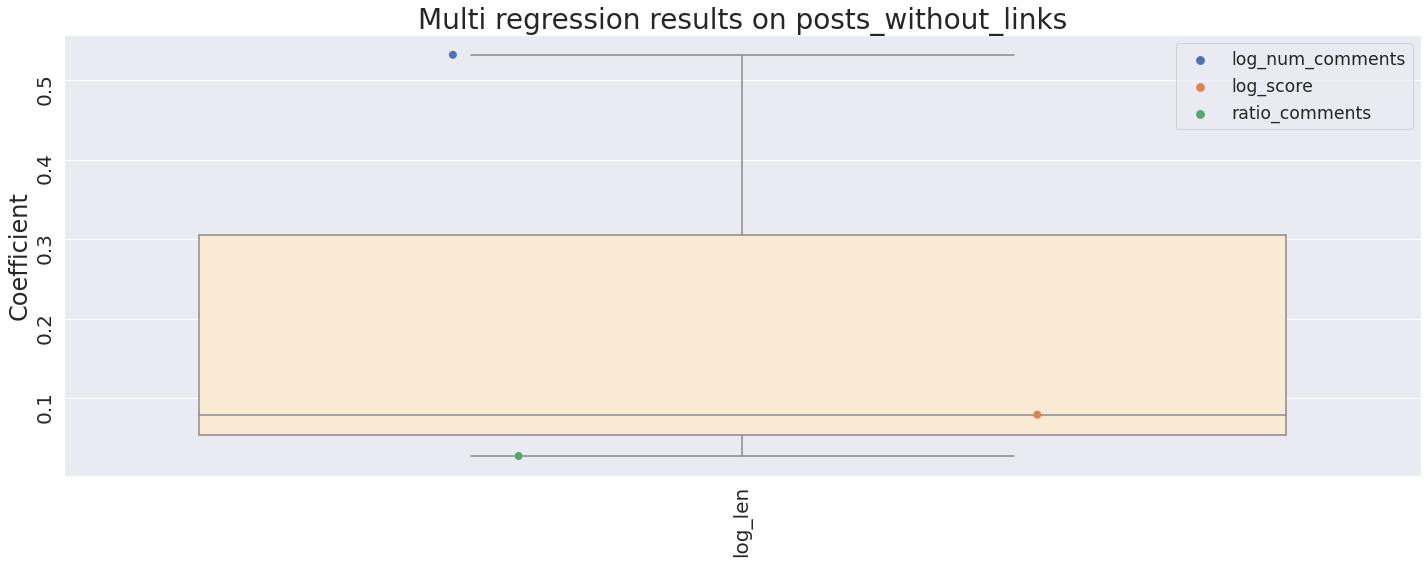

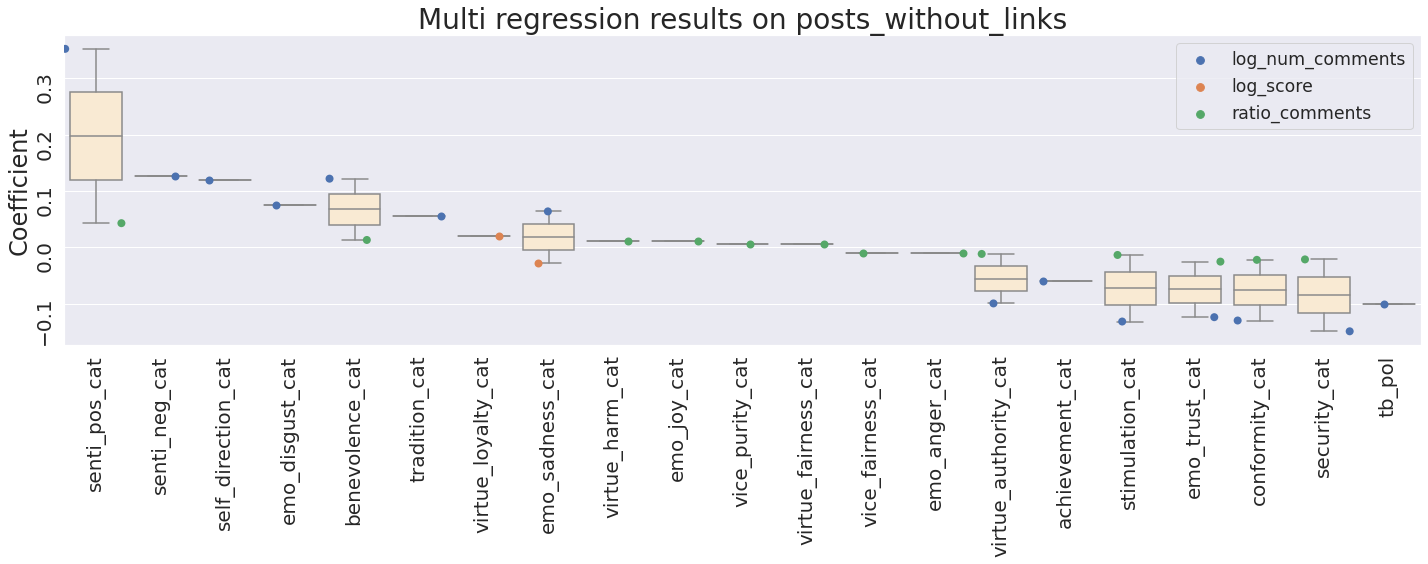

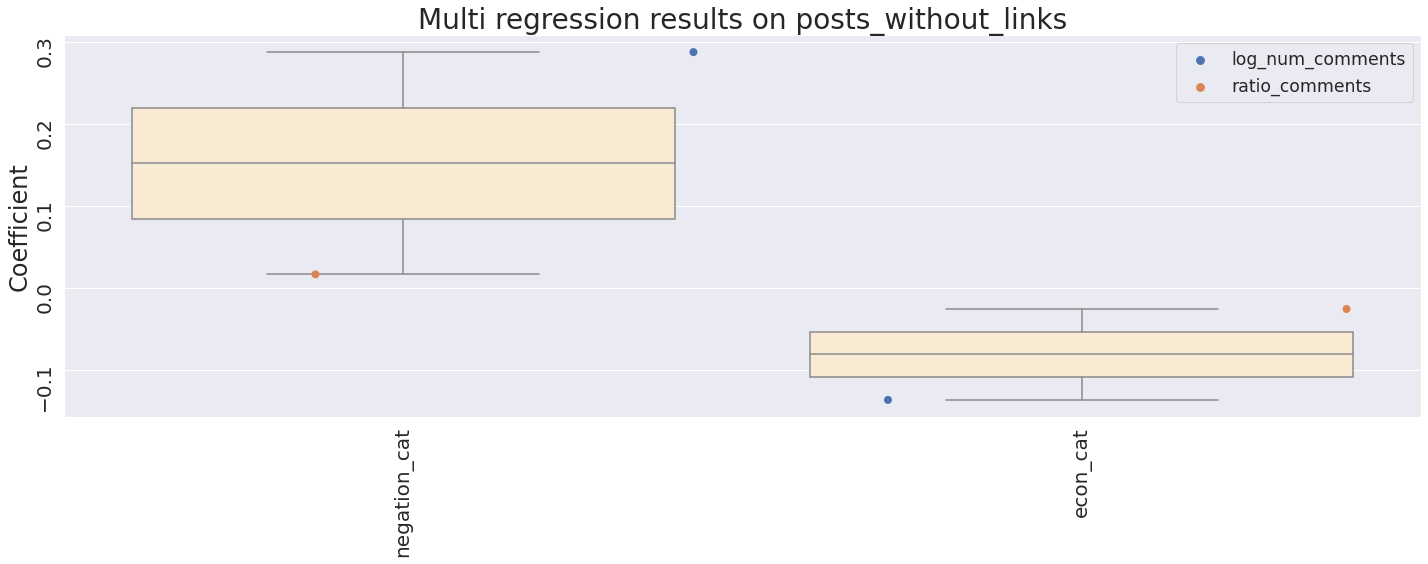

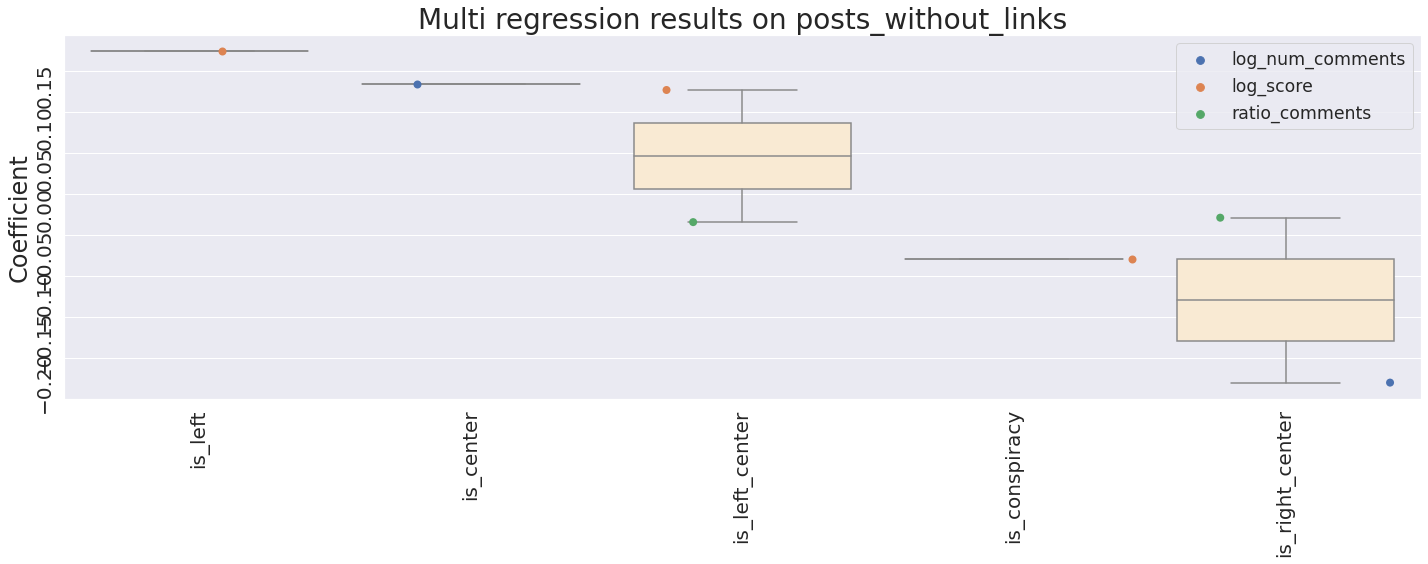

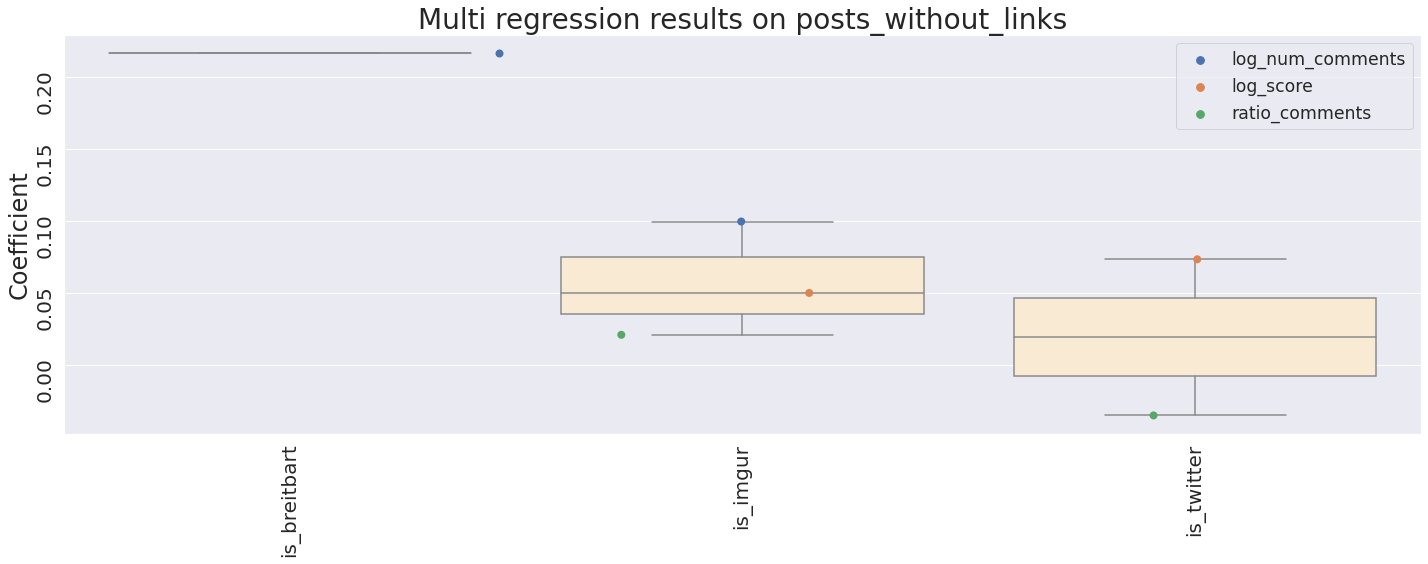

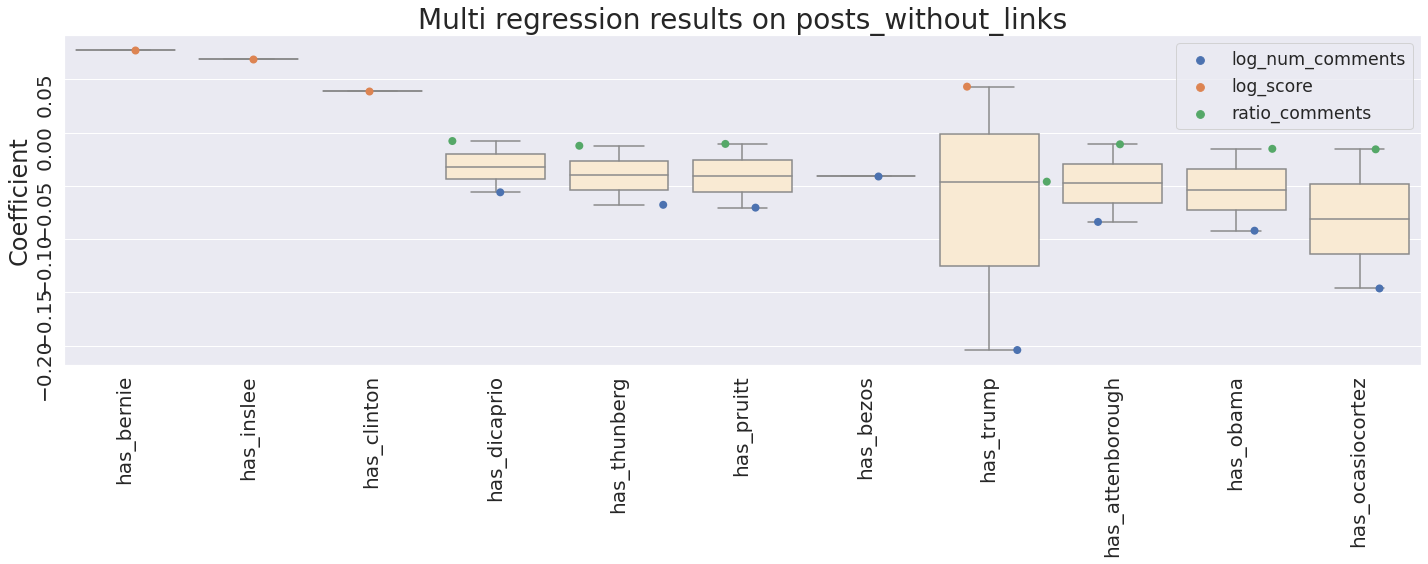

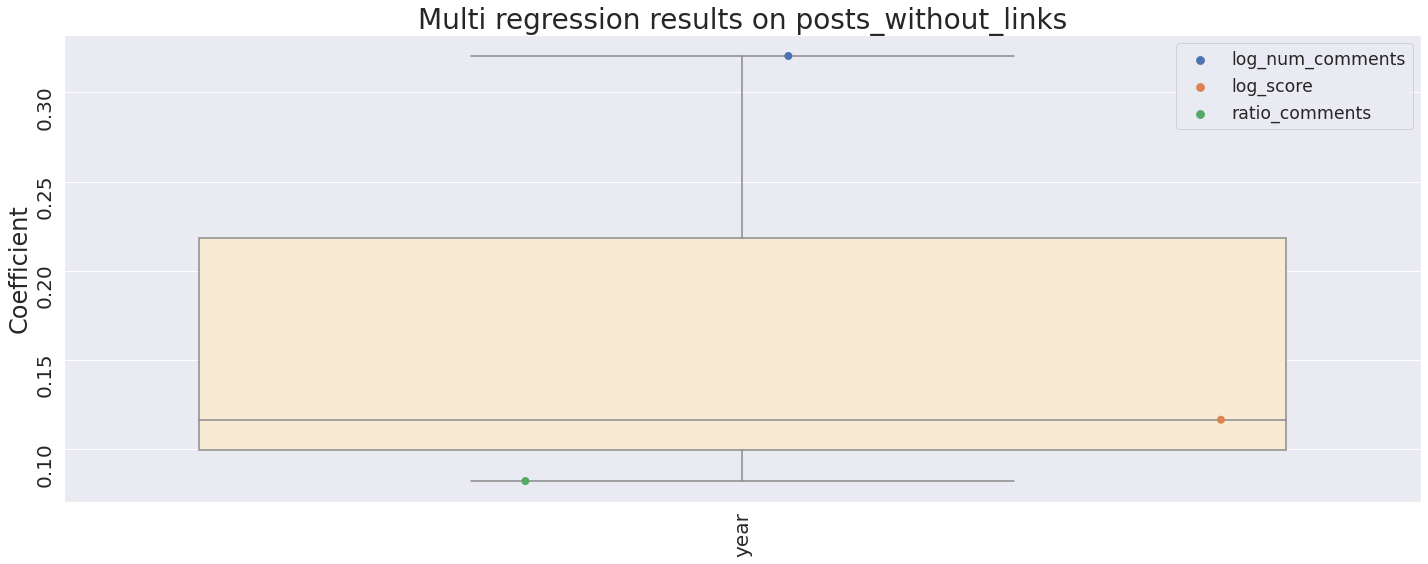

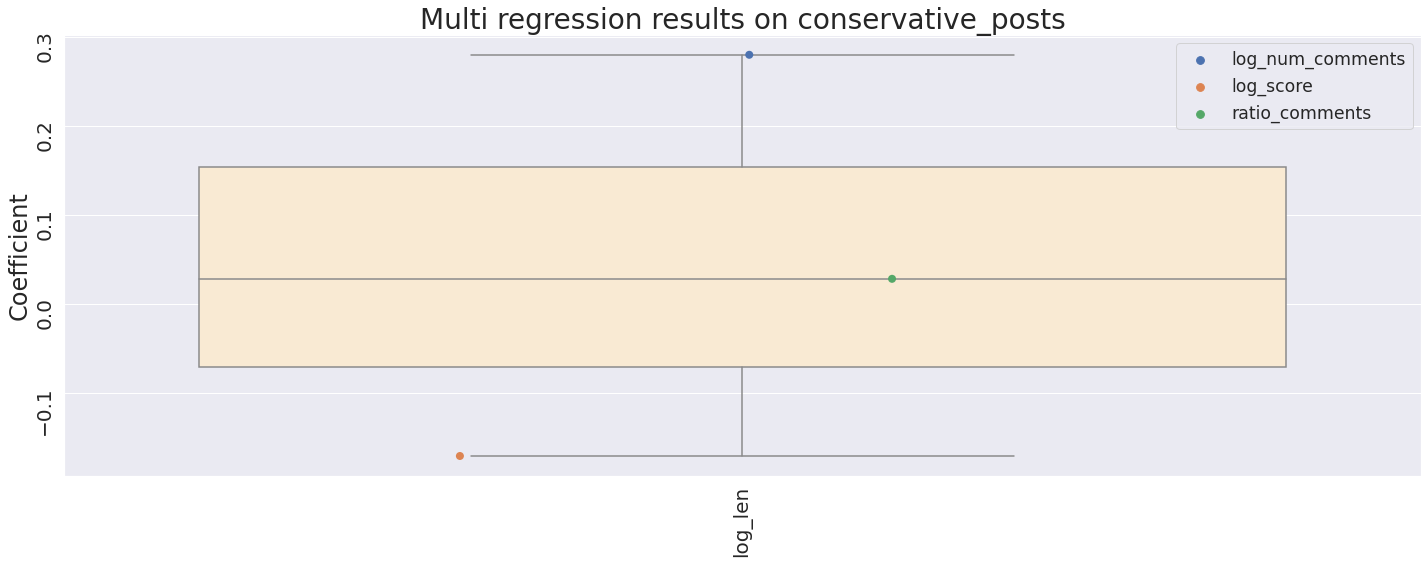

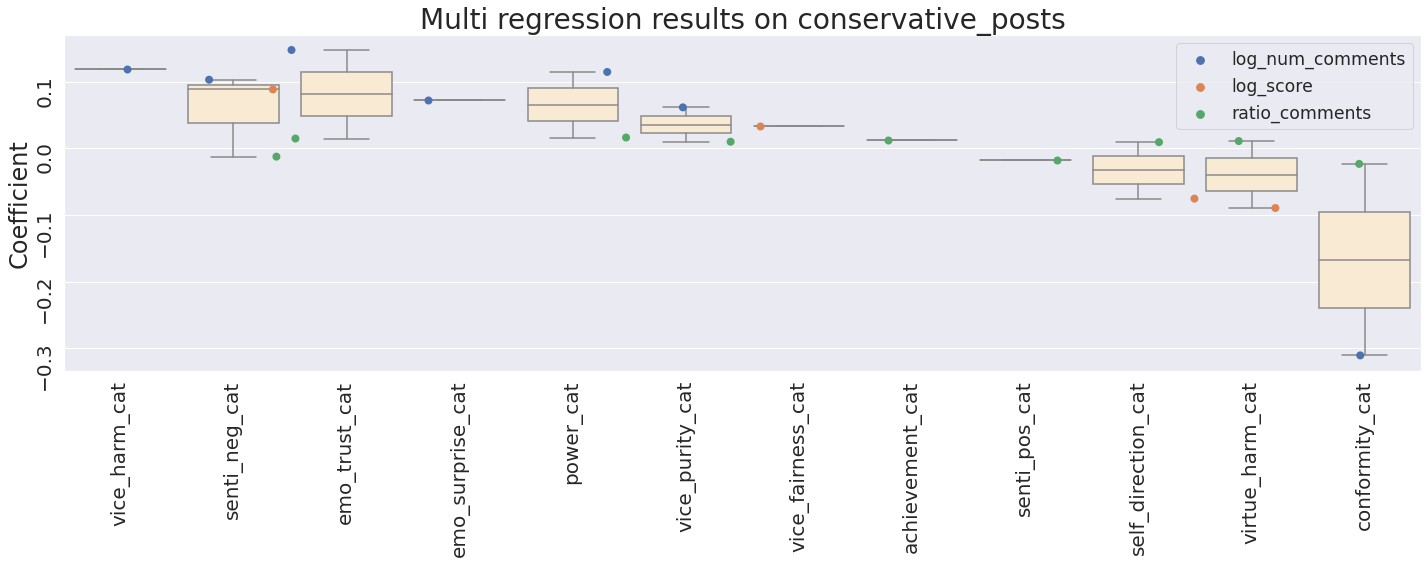

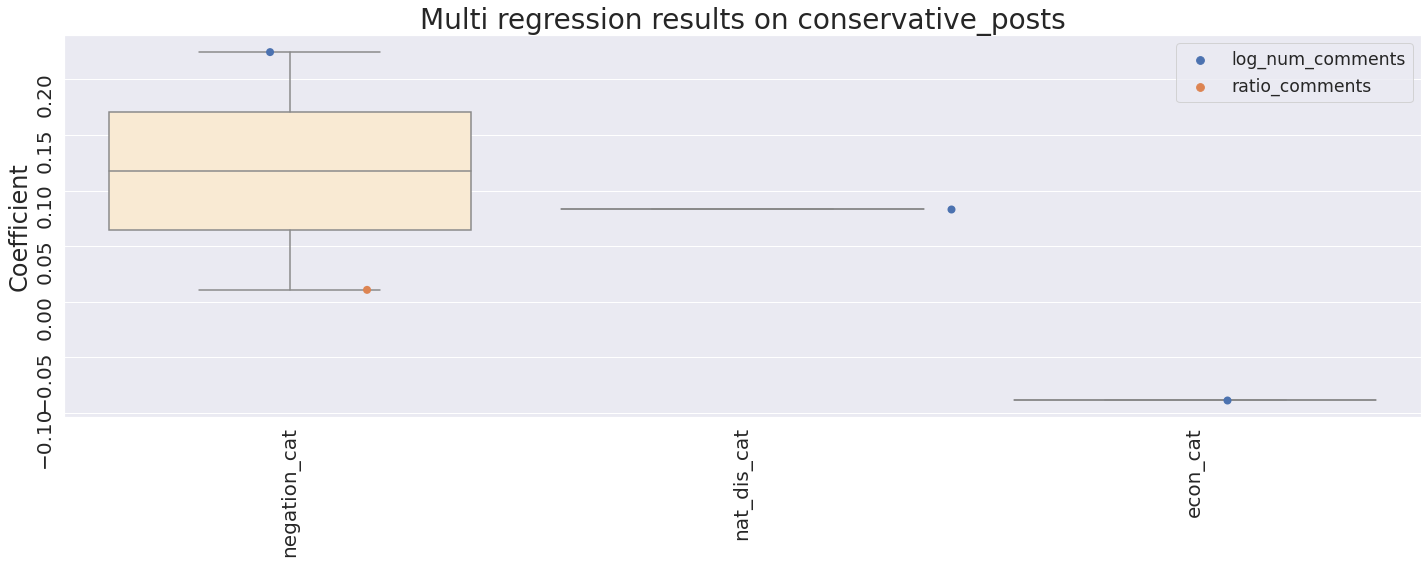

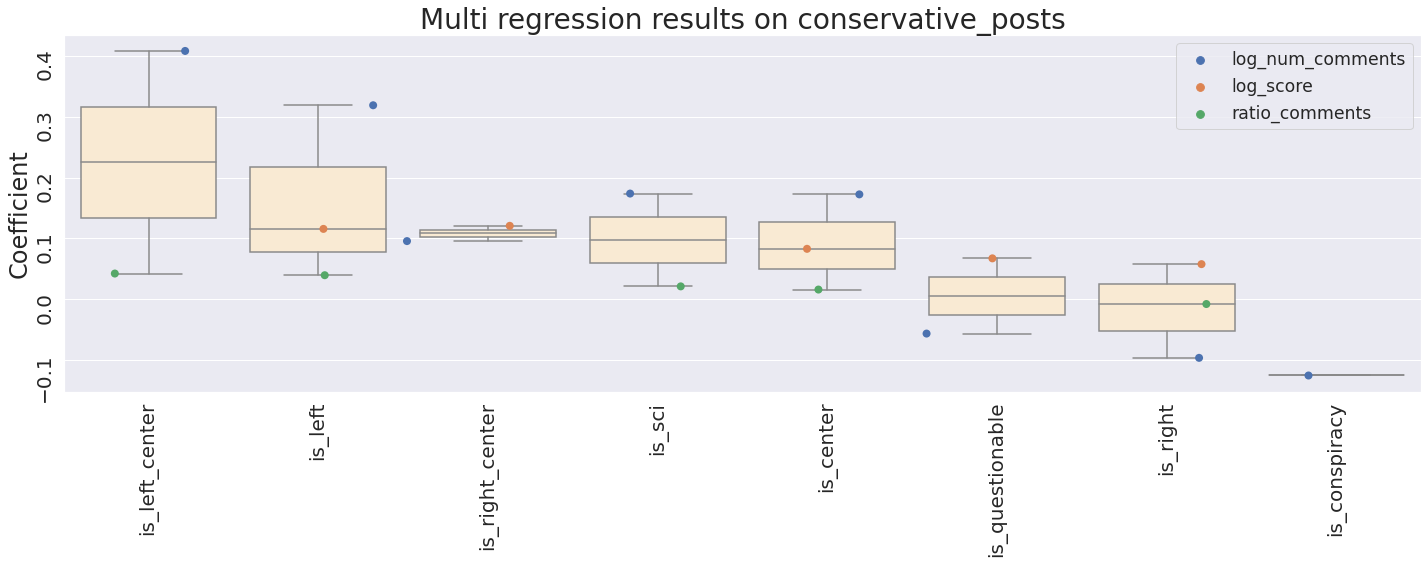

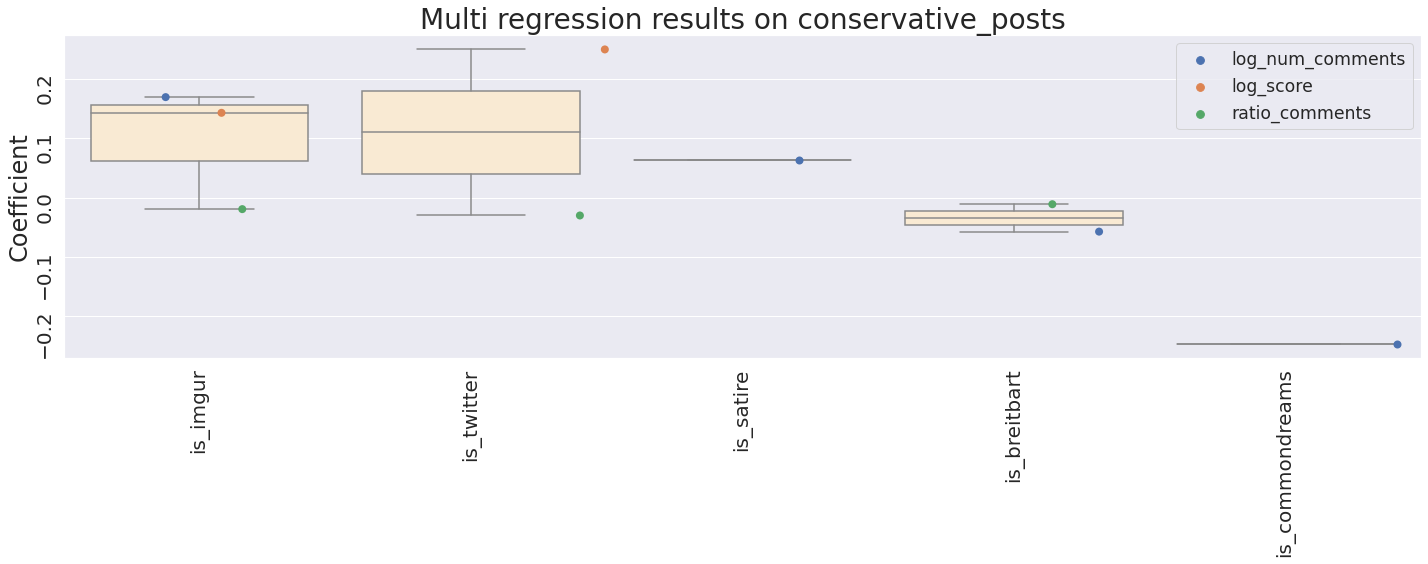

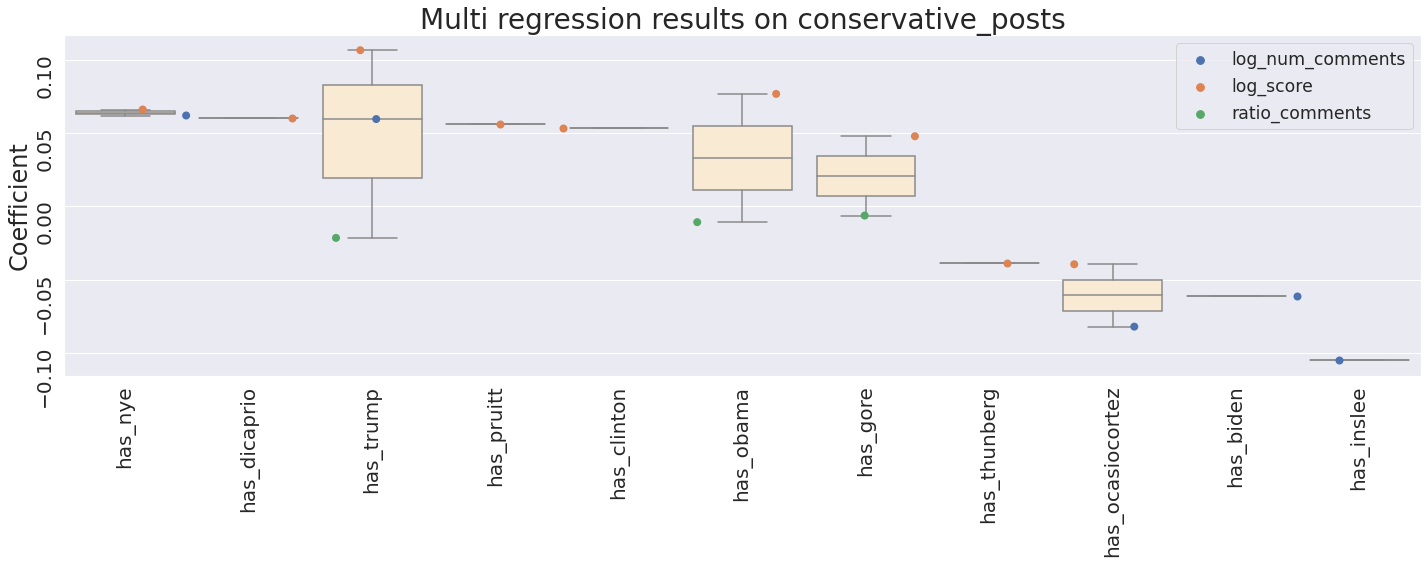

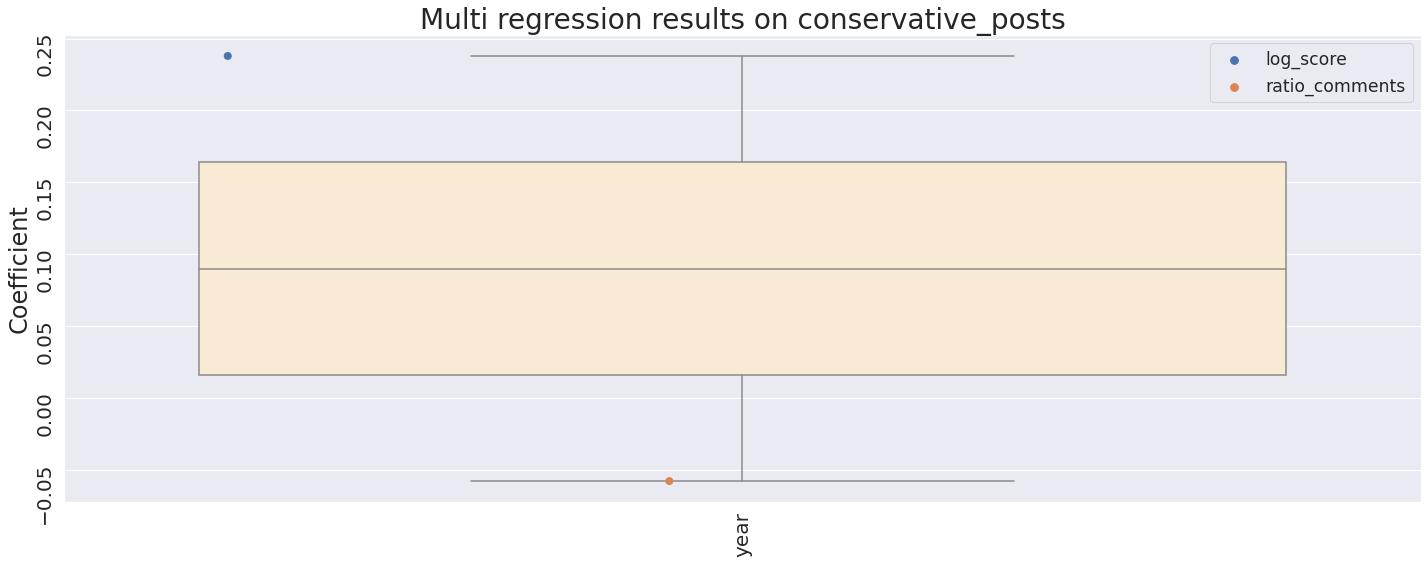

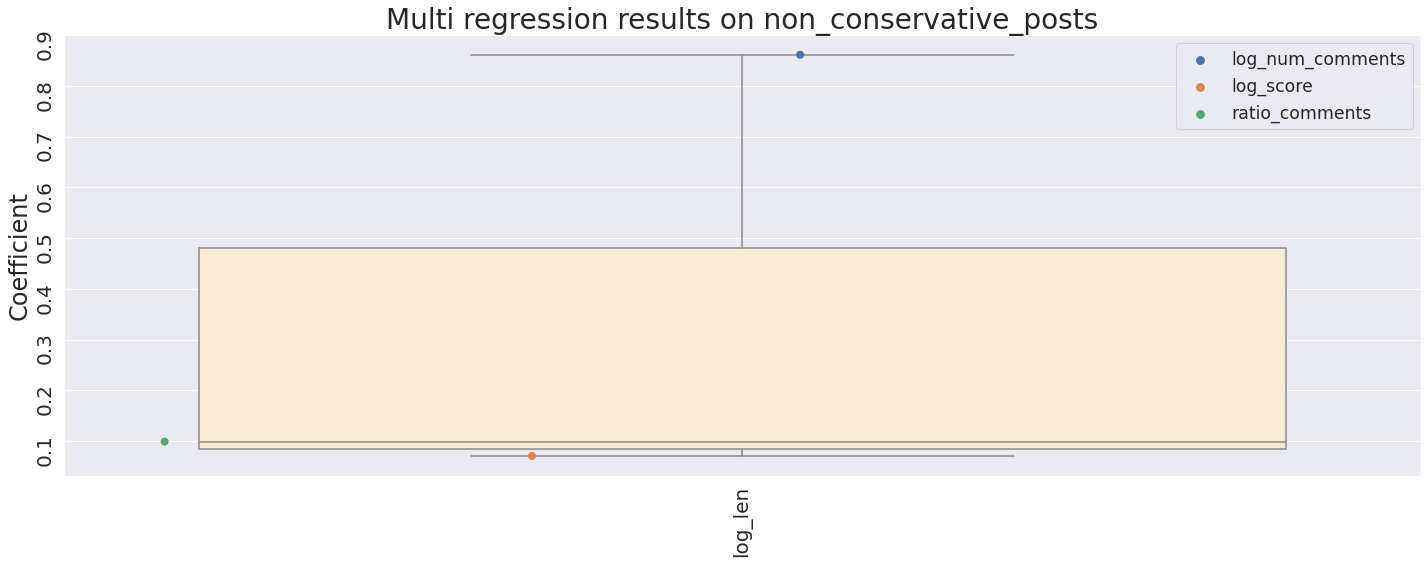

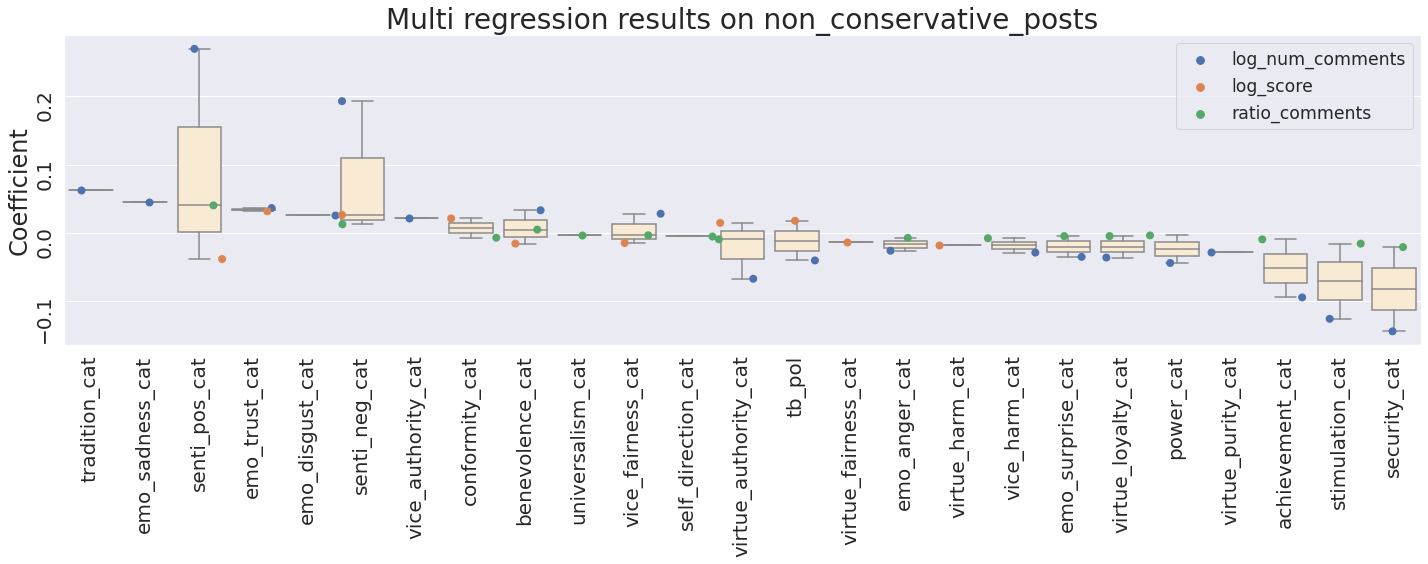

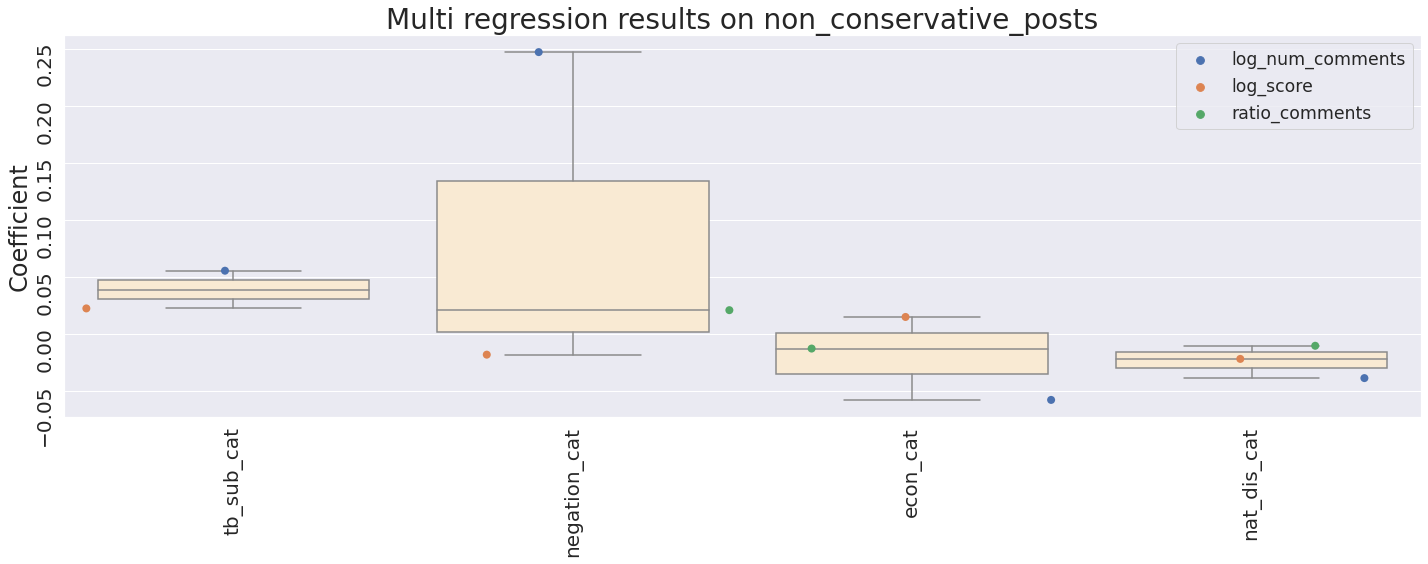

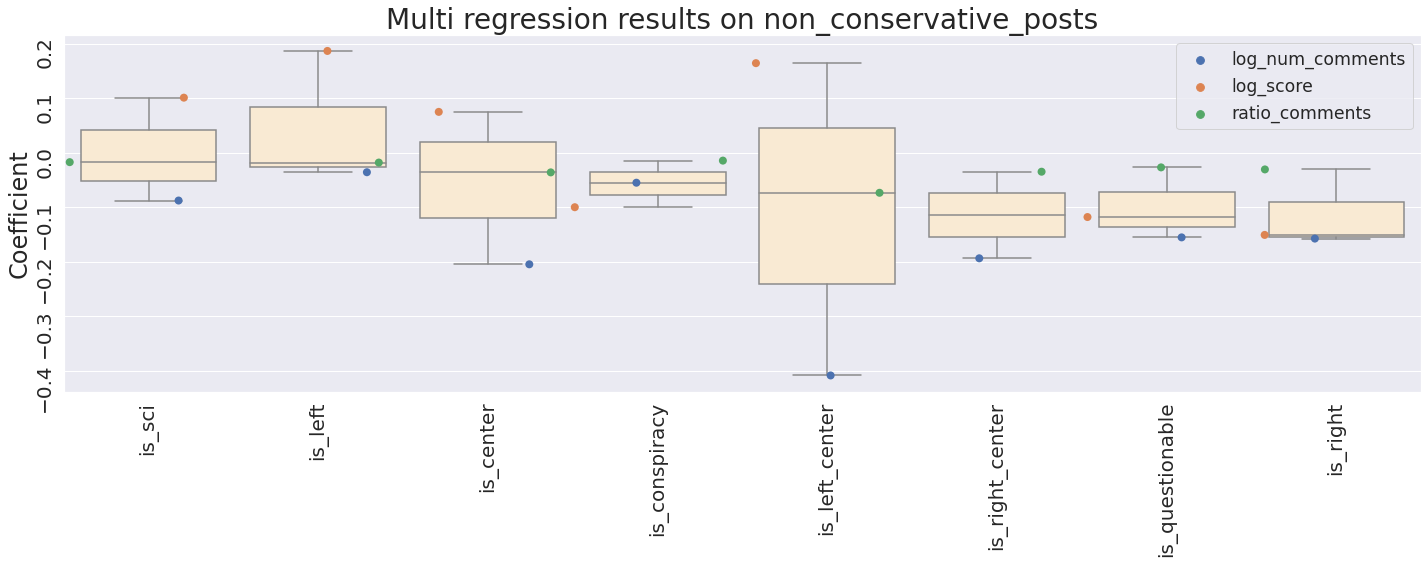

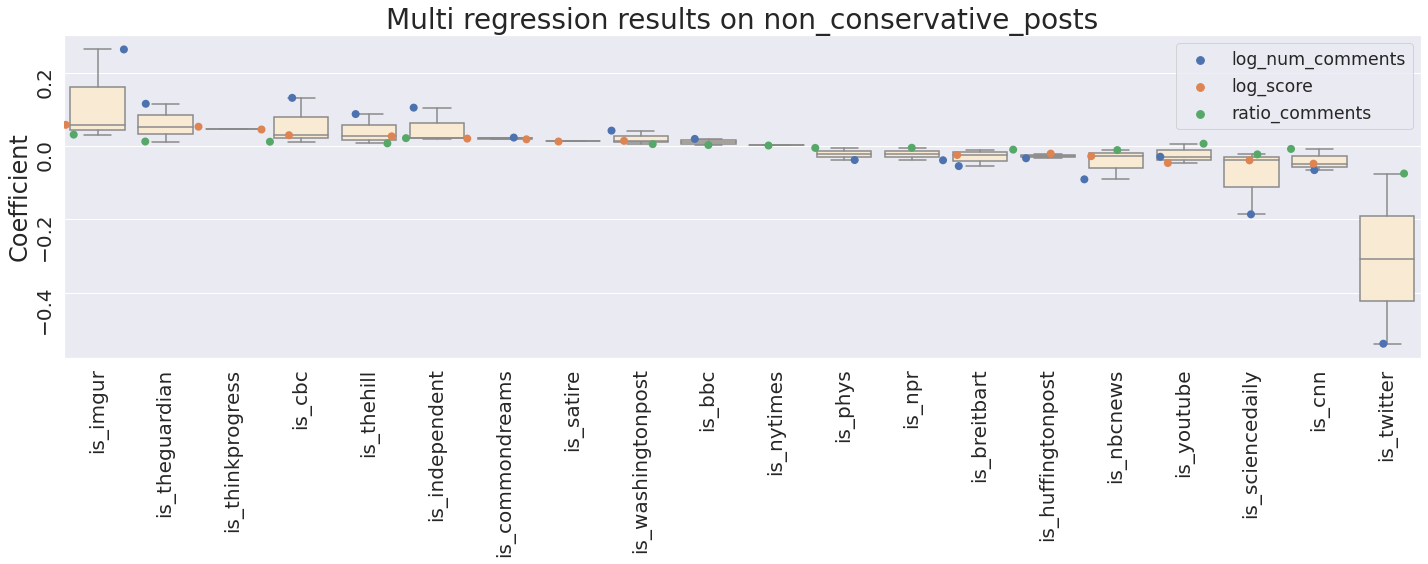

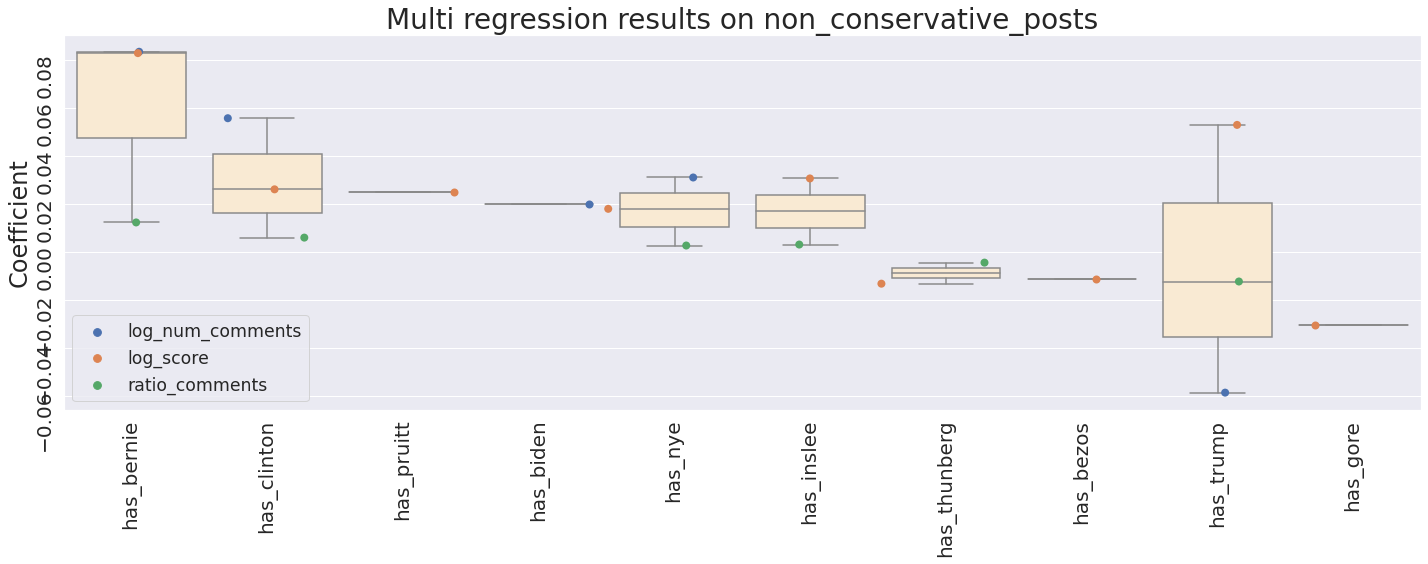

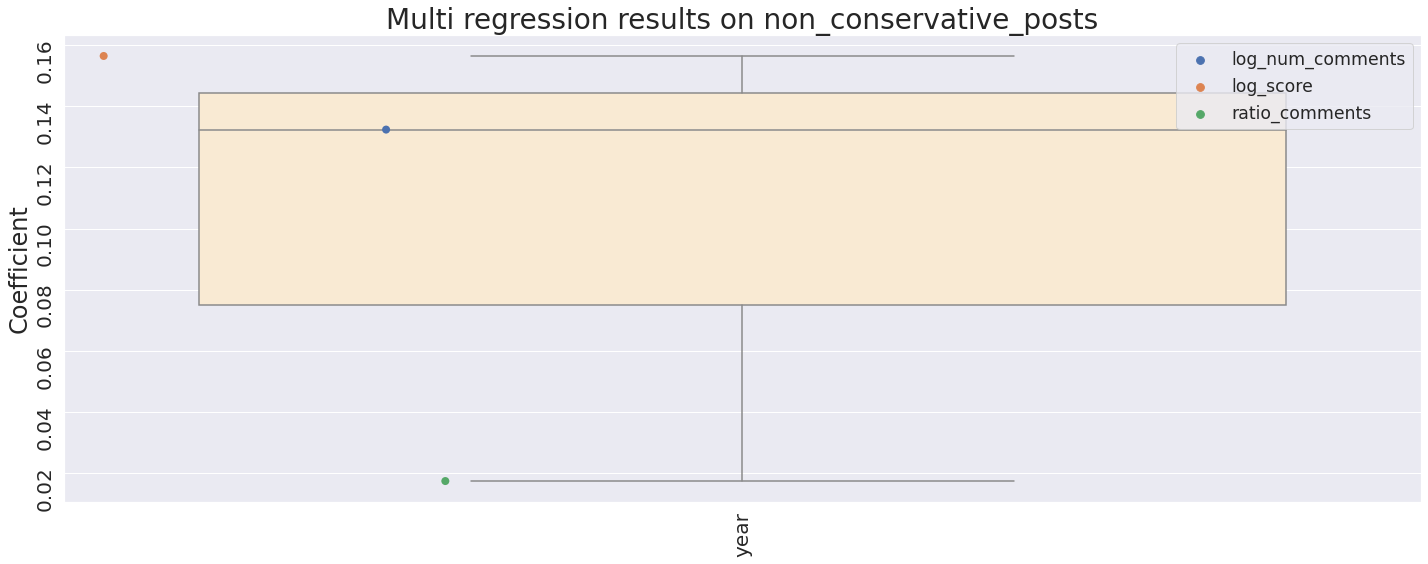

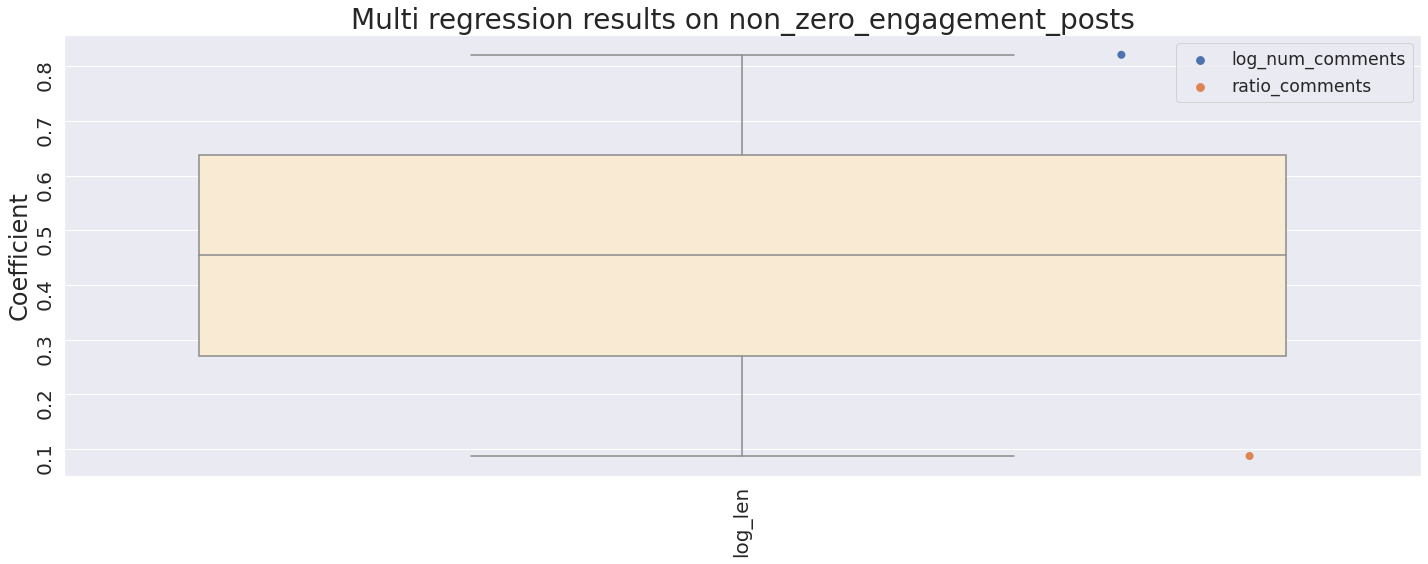

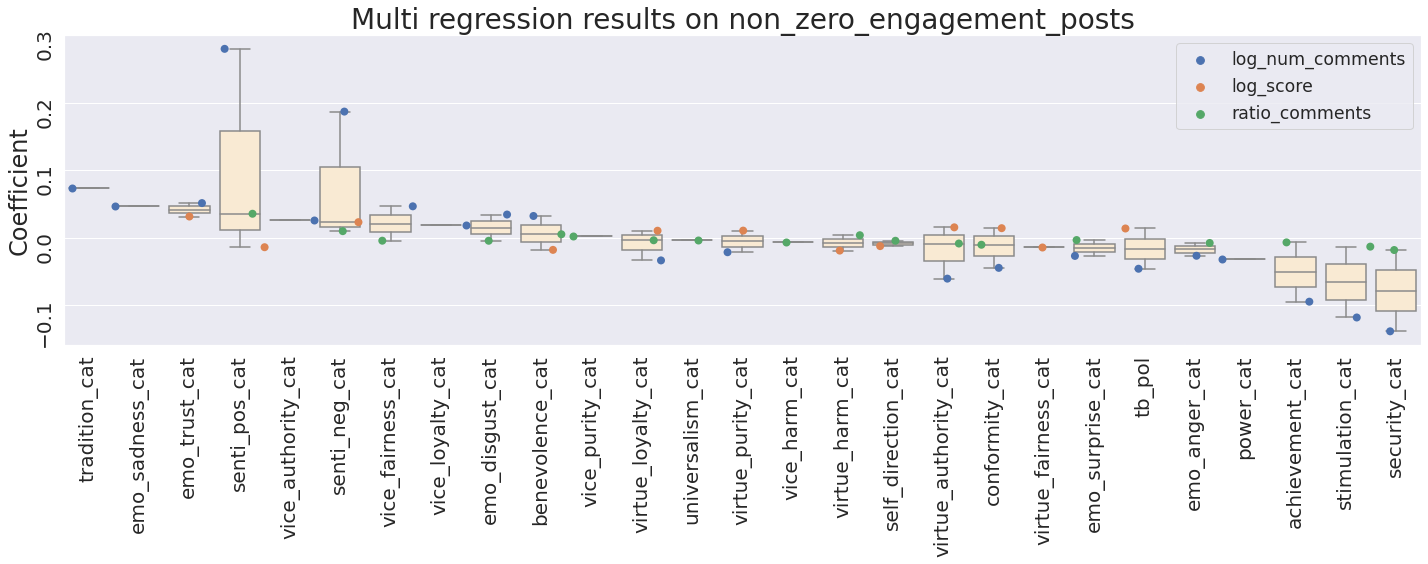

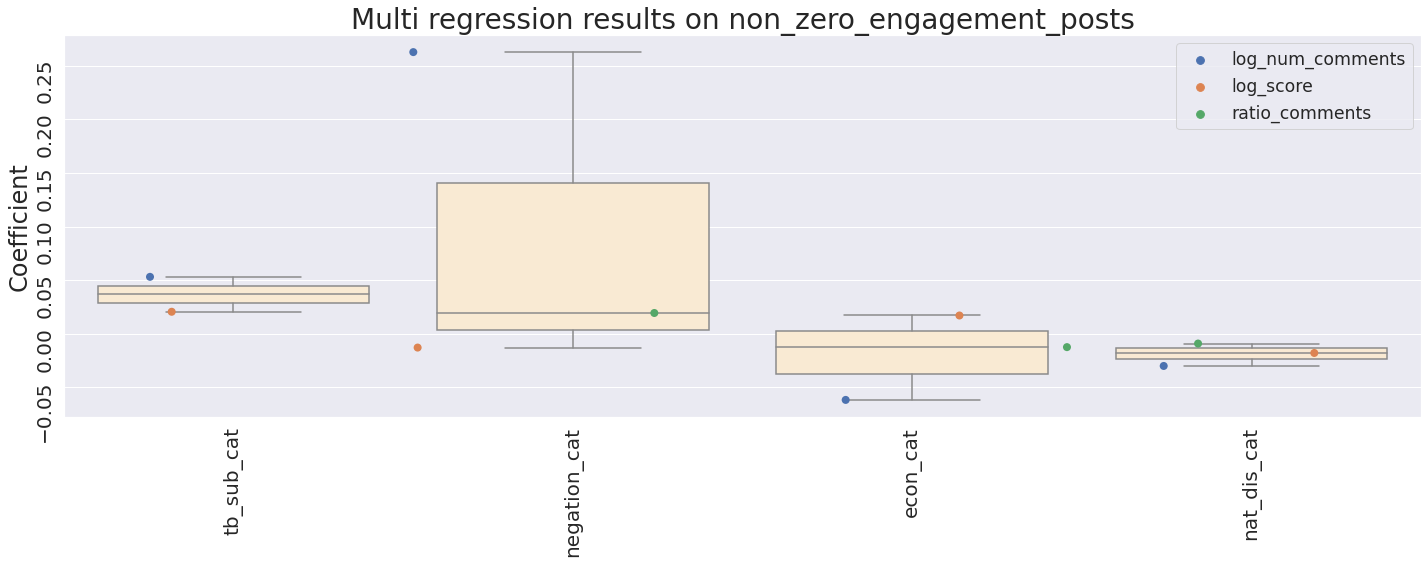

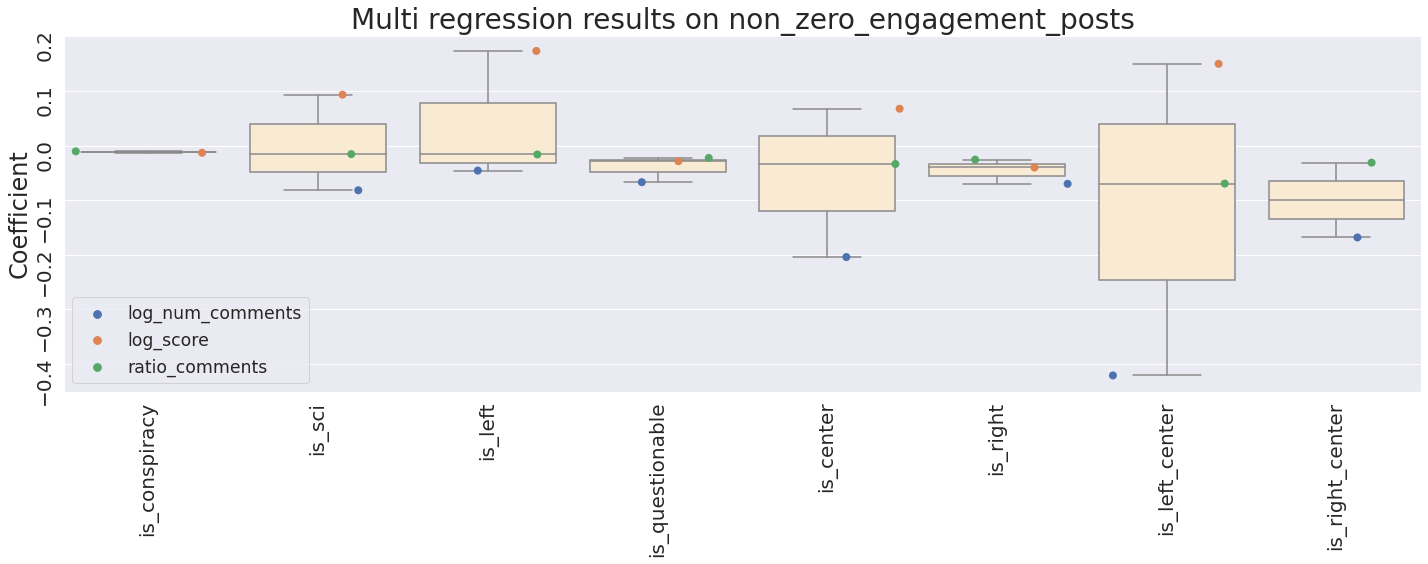

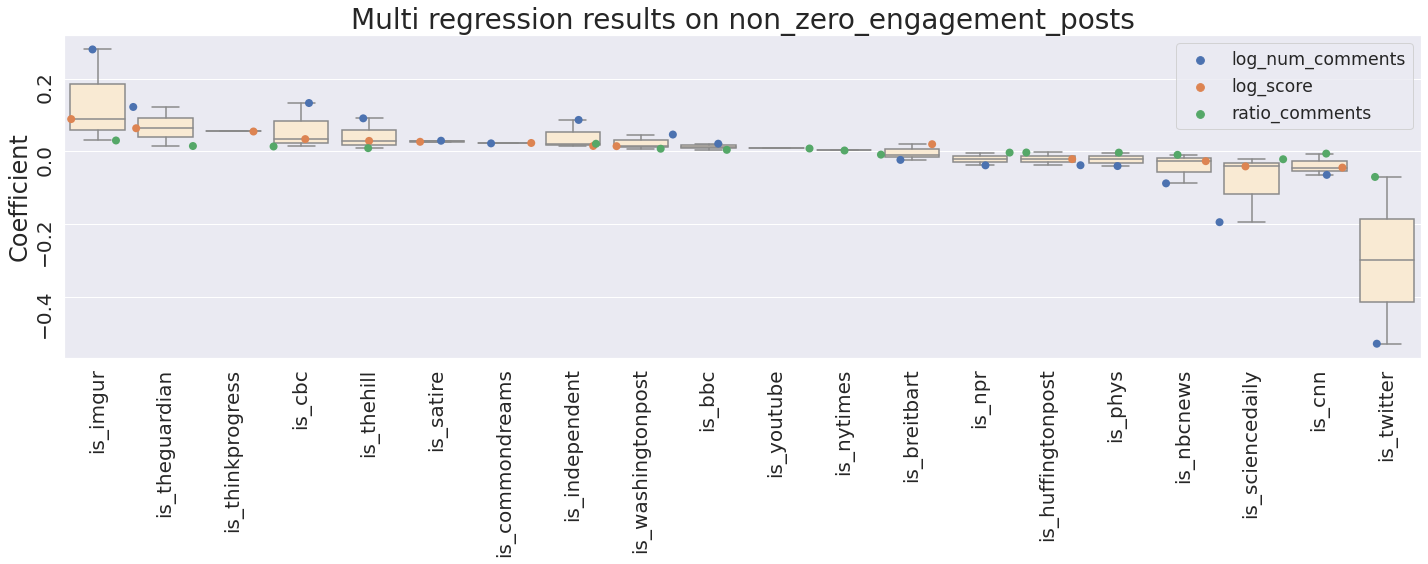

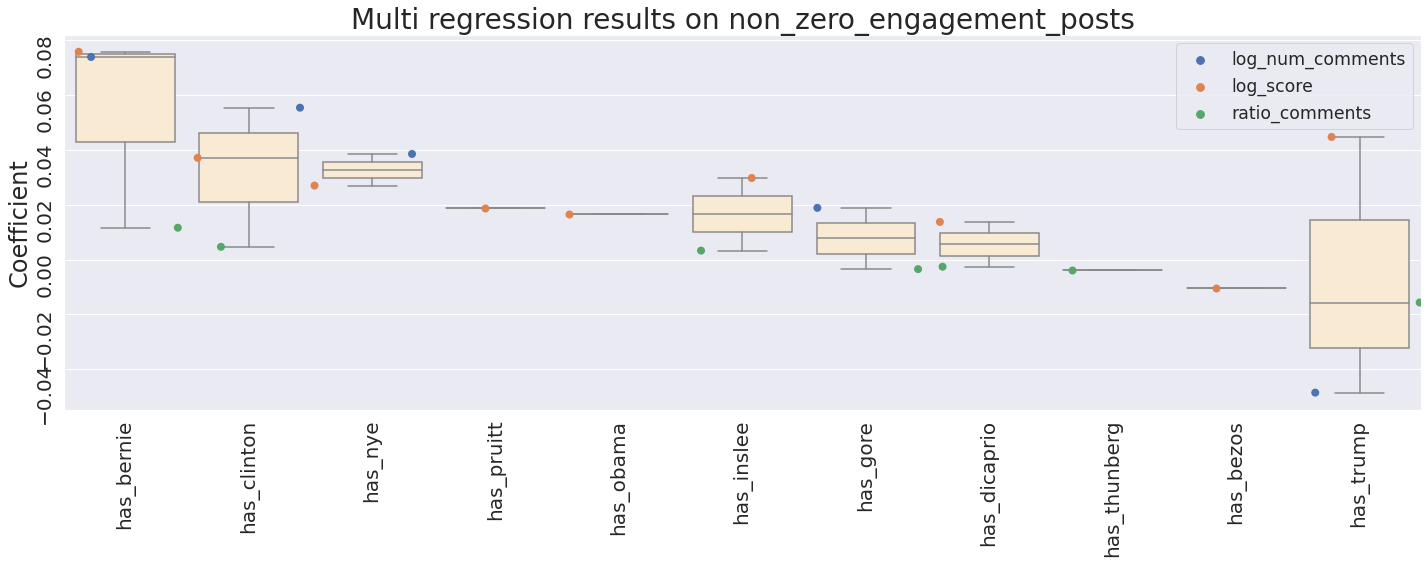

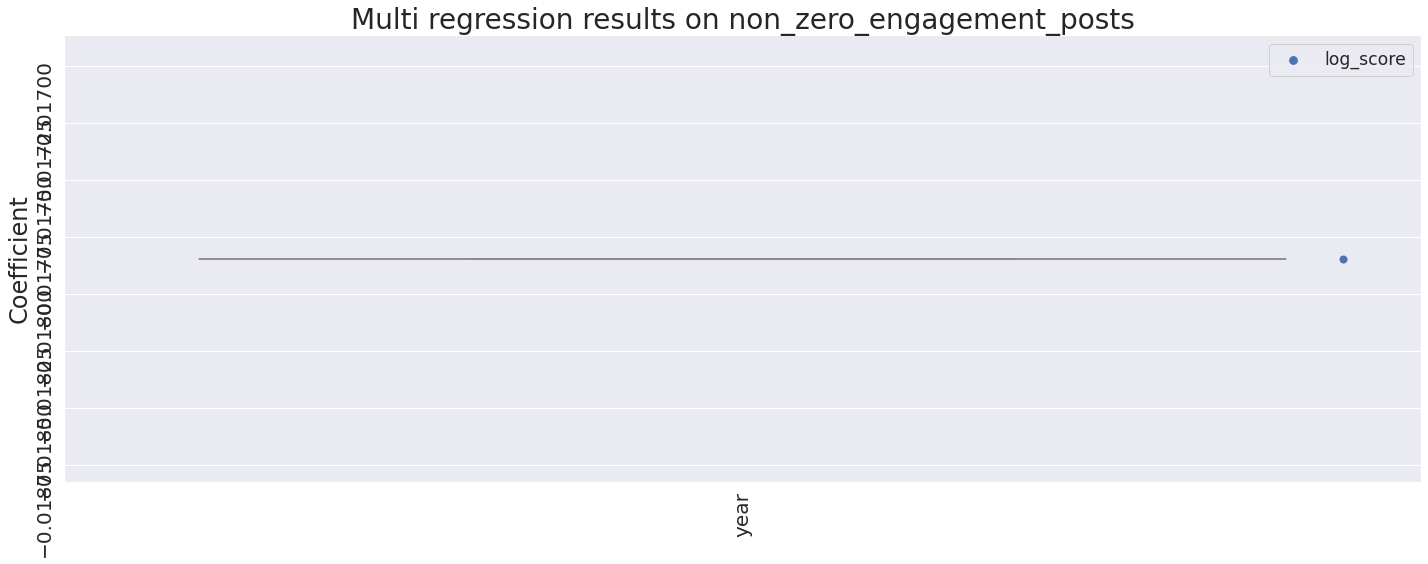

In [35]:
# do some plotting
for subset in LR.__dict__['subsets']:
    for feat_type in ['length', 'affect_cat', 'ling_cat', 'url_type', 'url_domain', 'people', 'time']:
        feature_set = dg_feats_dict[feat_type]
        savename = os.path.join(DG.get_out_dir(),'figs','{}_{}_effects'.format(subset,feat_type))
        LR.plot_coefficients(feature_set,subset,savename)

# Further exploration

In [36]:
fig_dir = os.path.join(DG.get_out_dir(),'figs')
fig_dir

'/u/scr/yiweil/Green-American-Lexicon/3_reddit_analysis/posts_with_words.pkl_out/figs'

## Example: pairwise correlation and pairplots

We can get the pairwise correlations among the dependent variables in our regression dataframe, and also create a pairplot using a sample of 1000 points.

In [37]:
lr_df = LR.get_base_df().copy()
to_plot = lr_df[LR.get_dep_vars()]

In [38]:
out = corr_data(to_plot,do_pairplot=True,pairplot_savename=os.path.join(fig_dir,'pairplot_ys.png'),pairplot_N=1000)

,log_num_comments,log_score,log_ratio_comments
log_num_comments,1.0***,0.2***,0.89***
log_score,0.2***,1.0***,0.13***
log_ratio_comments,0.89***,0.13***,1.0***


<Figure size 432x432 with 0 Axes>

## Example visualizing features broken down by subreddit

We can create boxplots for a given feature among the subreddits scoring high on that feature:

In [41]:
to_plot = lr_df
plot_sub_dist('emo_anger',to_plot,savename=os.path.join(fig_dir,'emo_anger_highest_subs.png'),top_N_=20)

<Figure size 720x576 with 0 Axes>

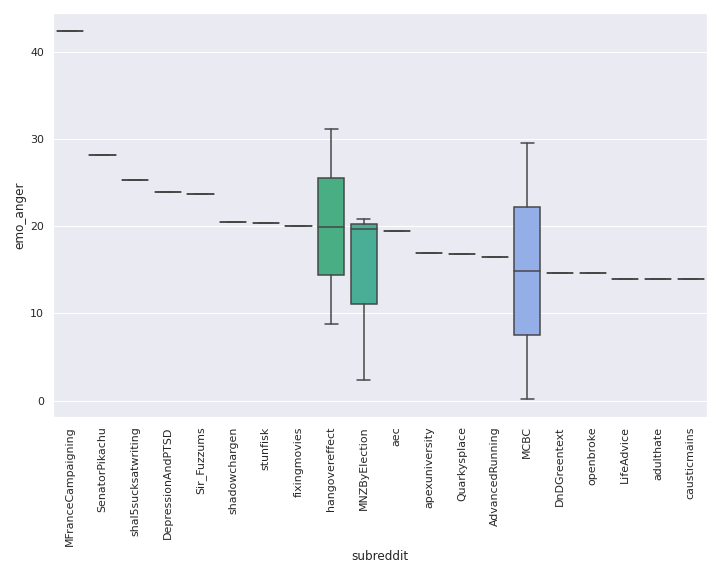

In [45]:
Image(os.path.join(fig_dir,'emo_anger_highest_subs.png'))

## Example: visualizing features across conservative and non-conservative subreddits

In [43]:
plot_sub_cat_dist('senti_pos',to_plot,savename=os.path.join(fig_dir,'senti_pos_R_vs_L.png'))

<Figure size 720x576 with 0 Axes>

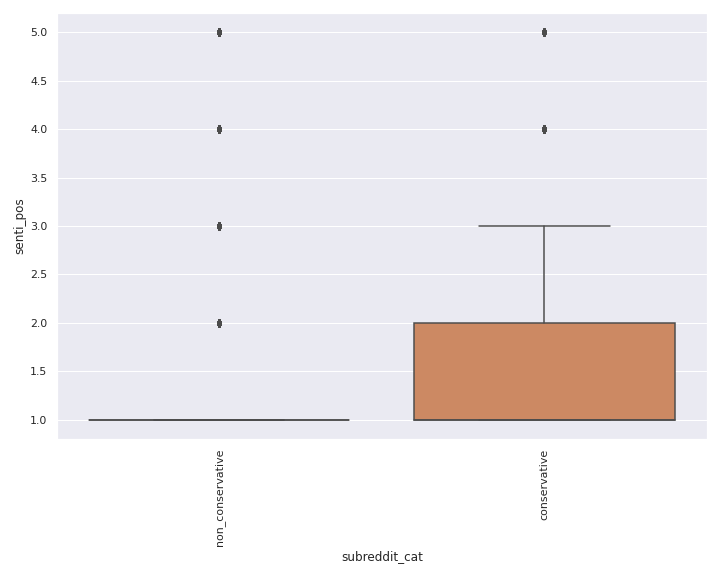

In [44]:
Image(os.path.join(fig_dir,'senti_pos_R_vs_L.png'))